In [136]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/daouda/.cache/torch/hub/v0.10.0.zip
/home/daouda/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daouda/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/daouda/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:12<00:00, 19.0MB/s] 


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# AlexNet

In [49]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.adaptive_avg_pooling = nn.AdaptiveAvgPool2d((6, 6))
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(self.maxpool(x)))
        x = self.relu(self.conv3(x))
        # Start the power measurement
        q = multiprocessing.Queue()
        q.put('start')
        p = multiprocessing.Process(target=measure, args=(q,))
        p.start()
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(self.maxpool(x)))
        x = self.adaptive_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(self.relu(x))
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        # Signal the end of the measurement
        q.put('stop')
        # Wait for the measurement to finish
        p.join()
        # Retrieve the power measurements from the queue
        while not q.empty():
            power_output = q.get()
            if power_output == 'stop':
                break
            print(power_output)
        return x


def measure(q, rq, gpu_ids):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=1 -i {gpu_ids}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
print(torch.cuda.device_count())
#print(torch.cuda.get_device_name(1))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")
model = AlexNet().to(device)
batch_size =128
X = torch.randn(size=(batch_size, 3, 227, 227)).type(FloatTensor).to(device)
model.train()
power_measurements = []

for i in range(30):
    # Start the power measurement
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue()
    

    # Signal the start of the measurement

    # Run the inference
    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started'                
    x = X.clone()
    x = model.conv1(x)
    x = model.relu(x)
    
    
    
    #x = model.maxpool(x)
    x = model.conv2(x)
    x = model.relu(x) 
    
    
    
    #x = model.maxpool(x)
    x = model.conv3(x)
    x = model.relu(x)
    
    
            
        

    x = model.conv4(x)
    x = model.relu(x) 
    
    
    x = model.conv5(x)
    x = model.relu(x)
    
    
    
    x = model.adaptive_avg_pooling(x)
    x = x.view(x.size(0), -1)
    x = model.dropout(x)
    
    #x = model.maxpool(x)
    x = model.fc1(x)
    x = model.dropout(model.relu(x)) 

    x = model.fc2(x)
    x = model.relu(x)

    x = model.fc3(x)
    q.put('stop')

    # Signal the end of the power measurement
    output = x

    # Wait for the measurement to finish
    p.join()

    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float
        
print(output.shape) 
mean_power = np.mean(power_measurements)
print("Mean power: ", mean_power)
percentile_90 = np.percentile(power_measurements, 95)
average_above_90th = np.mean(np.array(power_measurements)[np.array(power_measurements) >= percentile_90])
print('Average of values >= __th percentile:', average_above_90th)

use_cuda :  True
2
gotstarted


KeyboardInterrupt: 

In [17]:
print(power_measurements,'xxxxx',np.percentile(power_measurements, 99)) 


[72.94, 94.21, 86.97, 93.0, 91.56, 89.91, 90.69, 90.3, 90.61, 90.46, 90.28, 87.76, 89.15, 91.11, 90.49, 90.13, 91.36, 88.44, 89.13, 90.02, 87.99, 89.47, 90.77, 81.0, 88.26, 90.78, 89.65, 87.6, 88.26, 86.41] xxxxx 93.8591


Let's try it with 1 process for each layer

In [47]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.adaptive_avg_pooling = nn.AdaptiveAvgPool2d((6, 6))
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(self.maxpool(x)))
        x = self.relu(self.conv3(x))
        # Start the power measurement

        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(self.maxpool(x)))
        x = self.adaptive_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(self.relu(x))
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x


def measure(q, rq, gpu_ids):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=1 -i {gpu_ids}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


def inference():
    use_cuda = torch.cuda.is_available()
    print("use_cuda : ", use_cuda)
    print(torch.cuda.device_count())
    #print(torch.cuda.get_device_name(1))
    FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
    device = torch.device("cuda:0" if use_cuda else "cpu")
    model = AlexNet().to(device)
    batch_size =32
    X = torch.randn(size=(batch_size, 3, 227, 227)).type(FloatTensor).to(device)
    model.train()
    power_measurements = []
    for i in range(30):
        # Start the power measurement
        q = multiprocessing.Queue()
        rq = multiprocessing.Queue()
        q1 = multiprocessing.Queue()
        rq1 = multiprocessing.Queue()
        q2 = multiprocessing.Queue()
        rq2 = multiprocessing.Queue()
        q3 = multiprocessing.Queue()
        rq3 = multiprocessing.Queue()
        q4 = multiprocessing.Queue()
        rq4 = multiprocessing.Queue() 
        rq5 = multiprocessing.Queue()
        q5 = multiprocessing.Queue()
        rq6 = multiprocessing.Queue()
        q6 = multiprocessing.Queue()
        rq6 = multiprocessing.Queue()
        q7 = multiprocessing.Queue()
        rq7 = multiprocessing.Queue() 
        q8 = multiprocessing.Queue()
        rq8 = multiprocessing.Queue()

        # Signal the start of the measurement

        # Run the inference
        x = X.clone()
        p = multiprocessing.Process(target=measure, args=(q,rq,1))
        p.start()
        q.put('start')
        m = rq.get()
        print('got' + m)
        assert m == 'started'                  
        x = model.conv1(x)
        x = model.relu(x)
        q.put('stop')

        
        p1 = multiprocessing.Process(target=measure, args=(q1,rq1,1))
        p1.start()
        q1.put('start')
        m = rq1.get()
        print('got' + m)
        assert m == 'started'               
        #x = model.maxpool(x)
        x = model.conv2(x)
        x = model.relu(x) 
        q1.put('stop')
        
        
        p2 = multiprocessing.Process(target=measure, args=(q2,rq2,1))
        p2.start()
        q2.put('start')
        m = rq2.get()
        print('got' + m)
        assert m == 'started'              
        #x = model.maxpool(x)
        x = model.conv3(x)
        x = model.relu(x)
        q2.put('stop')
       
        
                
          
        p3 = multiprocessing.Process(target=measure, args=(q3,rq3,1))
        p3.start()
        q3.put('start')
        m = rq3.get()
        print('got' + m)
        assert m == 'started'          
        x = model.conv4(x)
        x = model.relu(x) 
        q3.put('stop')
        



        p4 = multiprocessing.Process(target=measure, args=(q4,rq4,1))
        p4.start()
        q4.put('start')
        m = rq4.get()
        print('got' + m)
        assert m == 'started'          
        x = model.conv5(x)
        x = model.relu(x)
        q4.put('stop')
        
        
      
        p5 = multiprocessing.Process(target=measure, args=(q5,rq5,1))
        p5.start()
        q5.put('start')
        m = rq5.get()
        print('got' + m)
        assert m == 'started'   
        x = model.adaptive_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = model.dropout(x)
        q5.put('stop')
        
        #x = model.maxpool(x)
        p6 = multiprocessing.Process(target=measure, args=(q6,rq6,1))
        p6.start()
        q6.put('start')
        m = rq6.get()
        print('got' + m)
        assert m == 'started'   
        x = model.fc1(x)
        x = model.dropout(model.relu(x)) 
        q6.put('stop')


        p7 = multiprocessing.Process(target=measure, args=(q7,rq7,1))
        p7.start()
        q7.put('start')
        m = rq7.get()
        print('got' + m)
        assert m == 'started'   
        x = model.fc2(x)
        x = model.relu(x)
        q7.put('stop')




        p8 = multiprocessing.Process(target=measure, args=(q8,rq8,1))
        p8.start()
        q8.put('start')
        m = rq8.get()
        print('got' + m)
        assert m == 'started'   
        x = model.fc3(x)
        q8.put('stop')

        # Signal the end of the power measurement
        output = x

        # Wait for the measurement to finish
        p.join() 
        p1.join()
        p2.join()
        p3.join()
        p4.join()
        p5.join()
        p6.join()
        p7.join()
        p8.join()


        # Retrieve the power measurements from the queue
        while not rq.empty():
            power_output = rq.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

        # Retrieve the power measurements from the queue
        while not rq1.empty():
            power_output = rq1.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov


        # Retrieve the power measurements from the queue
        while not rq2.empty():
            power_output = rq2.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov] 


        # Retrieve the power measurements from the queue
        while not rq3.empty():
            power_output = rq3.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

        # Retrieve the power measurements from the queue
        while not rq4.empty():
            power_output = rq4.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov


        # Retrieve the power measurements from the queue
        while not rq5.empty():
            power_output = rq5.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov] 
    
        # Retrieve the power measurements from the queue
        while not rq6.empty():
            power_output = rq6.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

        # Retrieve the power measurements from the queue
        while not rq7.empty():
            power_output = rq7.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov


        # Retrieve the power measurements from the queue
        while not rq8.empty():
            power_output = rq8.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov]
            
    print(output.shape) 
    mean_power = np.mean(power_measurements)
    print("Mean power: ", mean_power)
inference()

use_cuda :  True
2
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
41.02 W
49.37 W
70.87 W
76.47 W
59.15 W
39.76 W
40.44 W
39.47 W
38.89 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
40.83 W
48.59 W
67.96 W
74.65 W
62.85 W
39.48 W
39.77 W
39.28 W
38.90 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
41.12 W
48.89 W
65.35 W
76.00 W
62.85 W
39.38 W
40.16 W
39.67 W
38.89 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
41.01 W
48.79 W
66.80 W
76.12 W
62.94 W
39.28 W
40.36 W
39.49 W
38.99 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
41.51 W
48.50 W
66.91 W
75.02 W
63.03 W
39.09 W
39.96 W
39.47 W
39.10 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
41.22 W
48.89 W
68.55 W
72.

 Now let's repeat each layer several times 

In [5]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.adaptive_avg_pooling = nn.AdaptiveAvgPool2d((6, 6))
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(self.maxpool(x)))
        x = self.relu(self.conv3(x))
        # Start the power measurement

        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(self.maxpool(x)))
        x = self.adaptive_avg_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(self.relu(x))
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x


def measure(q, rq, gpu_ids):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=1 -i {gpu_ids}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


#def inference():
use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
print(torch.cuda.device_count())
#print(torch.cuda.get_device_name(1))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")
model = AlexNet().to(device)
batch_size =8
X = torch.randn(size=(batch_size, 3, 227, 227)).type(FloatTensor).to(device)
model.train()
power_measurements = [] 
power_measurements1 = []
power_measurements2 = []
power_measurements3 = []
power_measurements4 = []
power_measurements5 = []
power_measurements6 = []
power_measurements7 = []
power_measurements8 = []

for i in range(30):
    # Start the power measurement
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue()
    q1 = multiprocessing.Queue()
    rq1 = multiprocessing.Queue()
    q2 = multiprocessing.Queue()
    rq2 = multiprocessing.Queue()
    q3 = multiprocessing.Queue()
    rq3 = multiprocessing.Queue()
    q4 = multiprocessing.Queue()
    rq4 = multiprocessing.Queue() 
    rq5 = multiprocessing.Queue()
    q5 = multiprocessing.Queue()
    rq6 = multiprocessing.Queue()
    q6 = multiprocessing.Queue()
    rq6 = multiprocessing.Queue()
    q7 = multiprocessing.Queue()
    rq7 = multiprocessing.Queue() 
    q8 = multiprocessing.Queue()
    rq8 = multiprocessing.Queue()

    # Signal the start of the measurement

    # Run the inference
    x = X.clone()
    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started' 
    for i in range(1):                
        x1 = model.conv1(x)
        x1 = model.relu(x1)
    q.put('stop')
    p.join() 
    
    p1 = multiprocessing.Process(target=measure, args=(q1,rq1,1))
    p1.start()
    q1.put('start')
    m = rq1.get()
    print('got' + m)
    assert m == 'started'               
    #x = model.maxpool(x)
    for i in range(1):                
        x2 = model.conv2(x1)
        x2 = model.relu(x2) 
    q1.put('stop')
    p1.join()
    
    p2 = multiprocessing.Process(target=measure, args=(q2,rq2,1))
    p2.start()
    q2.put('start')
    m = rq2.get()
    print('got' + m)
    assert m == 'started'              
    #x = model.maxpool(x)
    for i in range(1):                
        x3 = model.conv3(x2)
        x3 = model.relu(x3)
    q2.put('stop')
    p2.join()       
    
            
        
    p3 = multiprocessing.Process(target=measure, args=(q3,rq3,1))
    p3.start()
    q3.put('start')
    m = rq3.get()
    print('got' + m)
    assert m == 'started' 
    for i in range(1):                         
        x4 = model.conv4(x3)
        x4 = model.relu(x4) 
    q3.put('stop')
    p3.join()
    



    p4 = multiprocessing.Process(target=measure, args=(q4,rq4,1))
    p4.start()
    q4.put('start')
    m = rq4.get()
    print('got' + m)
    assert m == 'started'
    for i in range(1):                          
        x5 = model.conv5(x4)
        x5 = model.relu(x5)
    q4.put('stop')
    p4.join()

    
    
    p5 = multiprocessing.Process(target=measure, args=(q5,rq5,1))
    p5.start()
    q5.put('start')
    m = rq5.get()
    print('got' + m)
    assert m == 'started'
    for i in range(1):                   
        x6 = model.adaptive_avg_pooling(x5)
        x6 = x6.view(x.size(0), -1)
        x6 = model.dropout(x6)
    q5.put('stop')
    p5.join()



    #x = model.maxpool(x)
    p6 = multiprocessing.Process(target=measure, args=(q6,rq6,1))
    p6.start()
    q6.put('start')
    m = rq6.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(1):                
        x7 = model.fc1(x6)
        x7 = model.dropout(model.relu(x7)) 
    q6.put('stop')
    p6.join()


    p7 = multiprocessing.Process(target=measure, args=(q7,rq7,1))
    p7.start()
    q7.put('start')
    m = rq7.get()
    print('got' + m)
    assert m == 'started'  
    for i in range(5):                 
        x8 = model.fc2(x7)
        x8 = model.relu(x8)
    q7.put('stop')
    p7.join()




    p8 = multiprocessing.Process(target=measure, args=(q8,rq8,1))
    p8.start()
    q8.put('start')
    m = rq8.get()
    print('got' + m)
    assert m == 'started'  
    for i in range(5):                 
        x9 = model.fc3(x8)
    q8.put('stop')
    p8.join()

    # Signal the end of the power measurement
    output = x9

    # Wait for the measurement to finish



    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq1.empty():
        power_output = rq1.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements1.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq2.empty():
        power_output = rq2.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements2.append(float(power_output.split()[0]))  # Remov] 


    # Retrieve the power measurements from the queue
    while not rq3.empty():
        power_output = rq3.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements3.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq4.empty():
        power_output = rq4.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements4.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq5.empty():
        power_output = rq5.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements5.append(float(power_output.split()[0]))  # Remov] 

    # Retrieve the power measurements from the queue
    while not rq6.empty():
        power_output = rq6.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements6.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq7.empty():
        power_output = rq7.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements7.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq8.empty():
        power_output = rq8.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements8.append(float(power_output.split()[0]))  # Remov]
        
print(output.shape) 
mean_power = np.mean(power_measurements)
print("conv1 power: ", mean_power) 
mean_power1 = np.mean(power_measurements1)
print("conv2 power: ", mean_power1) 
mean_power2 = np.mean(power_measurements2)
print("conv3 power: ", mean_power2)
mean_power3 = np.mean(power_measurements3)
print("conv4 power: ", mean_power3) 
mean_power4 = np.mean(power_measurements4)
print("conv5 power: ", mean_power4) 
mean_power5 = np.mean(power_measurements5)
print("avg drop power: ", mean_power5) 
mean_power6 = np.mean(power_measurements6)
print("fc1 power: ", mean_power6)
mean_power7 = np.mean(power_measurements7)
print("fc2 power: ", mean_power7) 
mean_power8 = np.mean(power_measurements8)
print("fc3 power: ", mean_power8)
#inference()

use_cuda :  True
2
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
39.37 W
42.88 W
49.66 W
50.93 W
47.14 W
39.18 W
40.35 W
41.61 W
39.58 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
39.49 W
42.77 W
48.50 W
48.88 W
46.37 W
39.09 W
39.86 W
41.81 W
39.58 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
39.48 W
42.68 W
48.69 W
50.91 W
46.56 W
39.08 W
39.67 W
41.81 W
39.58 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
39.48 W
42.86 W
48.69 W
50.83 W
45.20 W
38.99 W
39.87 W
41.82 W
39.58 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
39.49 W
42.78 W
48.49 W
49.86 W
46.66 W
38.99 W
39.86 W
41.32 W
39.57 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
39.68 W
42.96 W
48.41 W
51.

## Profiling Time 

In [29]:
import torch
import torch.nn as nn
import time as timer_l
import pandas as pd
import numpy as np
#from numba import cuda
import re

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.relu = nn.ReLU(inplace=True)
        self.maxpool2D = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.adaptive_avg_polling = nn.AdaptiveAvgPool2d((6, 6))
        self.dropout = nn.Dropout(p=0.5)

        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)

    def forward(self, x):
        with torch.autograd.profiler.record_function("conv1"):
            x = self.relu(self.conv1(x))
        with torch.autograd.profiler.record_function("Conv_2"):
            x = self.relu(self.conv2(x))
        with torch.autograd.profiler.record_function("conv3"):
            x = self.relu(self.conv3(x))
        with torch.autograd.profiler.record_function("conv4"):
            x = self.relu(self.conv4(x))
        with torch.autograd.profiler.record_function("conv5"):
            x = self.relu(self.conv5(x))
        with torch.autograd.profiler.record_function("avg_drop"):
            x = self.adaptive_avg_polling(x)
            x = x.view(x.size(0), -1)
            x = self.dropout(x)
        with torch.autograd.profiler.record_function("fc1"):
            x = self.fc1(x)
            x = self.dropout(self.relu(x))
        with torch.autograd.profiler.record_function("fc2"):
            x = self.fc2(x)
            x = self.relu(x)
        with torch.autograd.profiler.record_function("fc3"):
            x = self.fc3(x)
        return x

use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device= torch.device("cuda:0" if use_cuda else "cpu")
model = AlexNet().to(device)    
batch_size = 16
X = torch.randn(size=(batch_size, 3, 227, 227)).type(FloatTensor).to(device) 

# Run the model and record the inference time of each layer
for i in range(10):

    model.forward(X)
    profiler = torch.autograd.profiler.profile(enabled=True, use_cuda=True, record_shapes=True) 
    with profiler:
        #cuda.synchronize()
        output = model.forward(X)
        #cuda.synchronize()# Get the table of profiling results
profiling_results0 = profiler.key_averages().table()
print(profiling_results0)


use_cuda :  True


STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:311] Co

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                  conv1         0.59%      89.000us         1.82%     276.000us     276.000us       6.000us         0.07%     309.000us     309.000us             1  
                                           aten::conv2d         0.33%      50.000us         4.70%     714.000us     142.800us      19.000us         0.21%       7.750ms       1.550ms             5  
         

STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-06-07 06:53:28 48906:48906 ActivityProfilerController.cpp:321] Co

In [67]:


# Find the index of "Self CUDA time total"
start_index = profiling_results0.find("Self CUDA time total: ")
if start_index != -1:
    # Extract the substring starting from the index of the value
    start_index += len("Self CUDA time total: ")
    end_index = profiling_results0.find("ms", start_index)
    if end_index != -1:
        # Extract the value as a float
        self_cuda_time_total = float(profiling_results0[start_index:end_index].strip())
        print( self_cuda_time_total, "ms")


70.045 ms


In [52]:
import re

# Split the profiler table into lines
lines = profiling_results0.strip().split('\n')

# Define the layer names
layer_names = ['conv1', 'Conv_2', 'conv3', 'conv4', 'conv5', 'avg_drop', 'fc1', 'fc2', 'fc3']

# Extract the 'CUDA time avg' values for the specified layers and convert to ms
cuda_time_avgs = {}
for layer_name in layer_names:
    layer_line = next(line for line in lines if layer_name in line)
    cuda_time_avg_us = re.findall(r'\d+\.\d+(?:us|ms)', layer_line)[-1]
    cuda_time_avg_ms = float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0]) / 1000 if 'us' in cuda_time_avg_us else float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0])
    cuda_time_avgs[layer_name] = cuda_time_avg_ms

# Print the 'CUDA time avg' values in ms
for layer_name, cuda_time_avg in cuda_time_avgs.items():
    print(f"CUDA time avg for {layer_name}: {cuda_time_avg} ms")


CUDA time avg for conv1: 0.589 ms
CUDA time avg for Conv_2: 2.292 ms
CUDA time avg for conv3: 4.658 ms
CUDA time avg for conv4: 5.362 ms
CUDA time avg for conv5: 3.939 ms
CUDA time avg for avg_drop: 0.273 ms
CUDA time avg for fc1: 0.361 ms
CUDA time avg for fc2: 0.17 ms
CUDA time avg for fc3: 0.113 ms


In [81]:
import csv
import re
import pandas as pd

# Split the profiler table into lines
lines = profiling_results0.strip().split('\n')

# Define the layer names
layer_names = ['conv1', 'Conv_2', 'conv3', 'conv4', 'conv5', 'avg_drop', 'fc1', 'fc2', 'fc3']
power_measurements = [mean_power, mean_power1, mean_power2, mean_power3, mean_power4, mean_power5, mean_power6, mean_power7, mean_power8]

# Extract the 'CUDA time avg' values for the specified layers
cuda_time_avgs = {}
for layer_name in layer_names:
    layer_line = next(line for line in lines if layer_name in line)
    cuda_time_avg_us = re.findall(r'\d+\.\d+(?:us|ms)', layer_line)[-1]
    cuda_time_avg_ms = float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0]) / 1000 if 'us' in cuda_time_avg_us else float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0])
    cuda_time_avgs[layer_name] = cuda_time_avg_ms

power_idle = 38 #depends on the gpu
power_measurements_kernel = [power_measurement - power_idle for power_measurement in power_measurements]

# Calculate the energy by multiplying CUDA time avg and power measurements
energy_values = [cuda_time_avgs[layer_name] * power_measurements_kernel[i] for i, layer_name in enumerate(layer_names)]

# Save the results in a CSV file
csv_file = 'profiler_results_alexnet.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Layer Name', 'CUDA Time Avg (ms)', 'Power Measurements(W)','Power Kernel (W)', 'Energy(mJ)'])
    for i, layer_name in enumerate(layer_names):
        writer.writerow([layer_name, cuda_time_avgs[layer_name], power_measurements[i],power_measurements_kernel[i], energy_values[i]])

print(f"Profiler results saved in '{csv_file}'.")

# Read the CSV file
df = pd.read_csv(csv_file)

# Display the table
display(df)


Profiler results saved in 'profiler_results_alexnet.csv'.


,Layer Name,CUDA Time Avg (ms),Power Measurements(W),Power Kernel (W),Energy(mJ)
0,conv1,2.089,126.460667,88.460667,184.794333
1,Conv_2,8.848,143.769000,105.769000,935.844112
2,conv3,18.964,191.467667,153.467667,2910.360831
3,conv4,21.870,187.165333,149.165333,3262.245840
4,conv5,15.881,184.538667,146.538667,2327.180565
5,avg_drop,0.928,65.527667,27.527667,25.545675
6,fc1,0.871,76.480333,38.480333,33.516370
7,fc2,0.423,58.013667,20.013667,8.465781
8,fc3,0.171,50.399000,12.399000,2.120229


In [73]:
df['CUDA Time Avg (ms)'].sum() == self_cuda_time_total 

True

In [83]:
import pandas as pd

# Calculate the sum of energy for all layers
total_energy = df['Energy(mJ)'].sum()

# Extract the self CUDA time from the profiling results
self_cuda_time = self_cuda_time_total
power_idle = 38
# Multiply self CUDA time by X (adjust the value of X according to your needs)
X =average_above_90th - power_idle
result = self_cuda_time * X

# Create a new DataFrame with two columns
new_df = pd.DataFrame({'Sum of Energy': [total_energy], 'Self CUDA Time * X': [result]})

display(new_df)


,Sum of Energy,Self CUDA Time * X
0,9690.073736,7919.637925


## Bar Plot

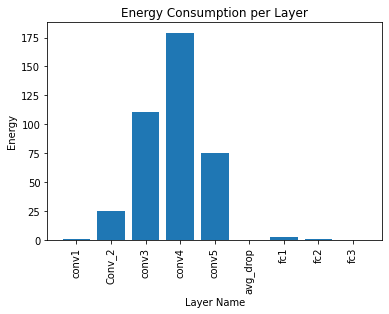

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(csv_file)

# Plot the values of energy in a bar plot
plt.bar(df['Layer Name'], df['Energy(mJ)'])
plt.xlabel('Layer Name')
plt.ylabel('Energy')
plt.title('Energy Consumption per Layer')
plt.xticks(rotation=90)
plt.show()

# Resnet 50

In [1]:
import torch
import torch.nn as nn


class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)


def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)


def test():
    net = ResNet18(img_channels=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())

'''
use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device= torch.device("cuda:1" if use_cuda else "cpu")
model = ResNet50(img_channels=3, num_classes=1000).to(device)    
batch_size = 1
X = torch.randn(size=(batch_size, 3, 227, 227)).type(FloatTensor).to(device) 
output = model.forward(X)
# Print the output tensor shape
print(output.shape)
'''

'\nuse_cuda = torch.cuda.is_available()\nprint("use_cuda : ", use_cuda)\nFloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor\ndevice= torch.device("cuda:1" if use_cuda else "cpu")\nmodel = ResNet50(img_channels=3, num_classes=1000).to(device)    \nbatch_size = 1\nX = torch.randn(size=(batch_size, 3, 227, 227)).type(FloatTensor).to(device) \noutput = model.forward(X)\n# Print the output tensor shape\nprint(output.shape)\n'

In [2]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements


import torch.nn as nn
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

    def ResNet50(img_channels=3, num_classes=1000):
        return ResNet(50, Block, img_channels, num_classes)
    
def measure(q, rq, gpu_ids):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=1 -i {gpu_ids}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")
model = ResNet50(img_channels=3, num_classes=1000).to(device)
batch_size = 64
X= torch.randn(size=(batch_size, 3, 224, 224)).type(FloatTensor).to(device)
model.train()
power_measurements = []

for i in range(30):
    # Start the power measurement
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue()
    

    # Signal the start of the measurement

    # Run the inference########################
    #
    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started'         
    #output = model.forward(X)   

    x = X.clone()
        
    x = model.conv1(x) 

    x = model.bn1(x)

    x = model.relu(x)

    x = model.maxpool(x)

    x = model.layer1(x)

    x = model.layer2(x)

    x = model.layer3(x)
    
    x = model.layer4(x)

    x = model.avgpool(x)

    x = x.reshape(x.shape[0], -1)

    x = model.fc(x)
    
    output = x
    q.put('stop')


    #################

    # Wait for the measurement to finish
    p.join()

    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float
        
print(output.shape) 
mean_power = np.mean(power_measurements)
print("Mean power: ", mean_power)
percentile_90 = np.percentile(power_measurements, 95)
average_above_90th = np.mean(np.array(power_measurements)[np.array(power_measurements) >= percentile_90])
print('Average of values >= __th percentile:', average_above_90th) 

use_cuda :  True
gotstarted
45.39 W
gotstarted
129.06 W
gotstarted
123.41 W
gotstarted
132.33 W
gotstarted
128.19 W
gotstarted
128.05 W
gotstarted
123.70 W
gotstarted
130.81 W
gotstarted
129.60 W
gotstarted
124.14 W
gotstarted
123.93 W
gotstarted
124.67 W
gotstarted
126.46 W
gotstarted
136.15 W
gotstarted
123.62 W
gotstarted
134.33 W
gotstarted
127.88 W
gotstarted
127.24 W
gotstarted
124.86 W
gotstarted
127.66 W
gotstarted
123.42 W
gotstarted
127.80 W
gotstarted
128.58 W
gotstarted
129.16 W
gotstarted
144.92 W
gotstarted
128.65 W
gotstarted
124.71 W
gotstarted
125.29 W
gotstarted
137.40 W
gotstarted
128.81 W
torch.Size([64, 1000])
Mean power:  125.67399999999999
Average of values >= __th percentile: 141.16


In [ ]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements


import torch.nn as nn
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

    def ResNet50(img_channels=3, num_classes=1000):
        return ResNet(50, Block, img_channels, num_classes)
    
def measure(q, rq, gpu_ids):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=1 -i {gpu_ids}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


def inference():
    use_cuda = torch.cuda.is_available()
    print("use_cuda : ", use_cuda)
    FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
    device = torch.device("cuda:0" if use_cuda else "cpu")
    model = ResNet50(img_channels=3, num_classes=1000).to(device)
    batch_size = 64
    X= torch.randn(size=(batch_size, 3, 224, 224)).type(FloatTensor).to(device)
    model.train()
    power_measurements = [] 
    for i in range(30):
        # Start the power measurement
        q = multiprocessing.Queue()
        rq = multiprocessing.Queue()
        q1 = multiprocessing.Queue()
        rq1 = multiprocessing.Queue()
        q2 = multiprocessing.Queue()
        rq2 = multiprocessing.Queue()
        q3 = multiprocessing.Queue()
        rq3 = multiprocessing.Queue()
        q4 = multiprocessing.Queue()
        rq4 = multiprocessing.Queue() 
        rq5 = multiprocessing.Queue()
        q5 = multiprocessing.Queue()
        rq6 = multiprocessing.Queue()
        q6 = multiprocessing.Queue()
        rq6 = multiprocessing.Queue()
        q7 = multiprocessing.Queue()
        rq7 = multiprocessing.Queue() 
        q8 = multiprocessing.Queue()
        rq8 = multiprocessing.Queue() 
        q9 = multiprocessing.Queue()
        rq9 = multiprocessing.Queue()

        # Signal the start of the measurement

        # Run the inference
        p = multiprocessing.Process(target=measure, args=(q,rq,1))
        p.start()
        q.put('start')
        m = rq.get()
        print('got' + m)
        assert m == 'started'         
        x = X.clone()
        x = model.conv1(x) 
        q.put('stop')

        
        p1 = multiprocessing.Process(target=measure, args=(q1,rq1,1))
        p1.start()
        q1.put('start')
        m = rq1.get()
        print('got' + m)
        assert m == 'started'               
        #x = model.maxpool(x)
        x = model.bn1(x)
        q1.put('stop')
        
        
        p2 = multiprocessing.Process(target=measure, args=(q2,rq2,1))
        p2.start()
        q2.put('start')
        m = rq2.get()
        print('got' + m)
        assert m == 'started'              
        #x = model.maxpool(x)
        x = model.relu(x)
        q2.put('stop')
       
        
                
          
        p3 = multiprocessing.Process(target=measure, args=(q3,rq3,1))
        p3.start()
        q3.put('start')
        m = rq3.get()
        print('got' + m)
        assert m == 'started'          
        x = model.maxpool(x)
        q3.put('stop')
        



        p4 = multiprocessing.Process(target=measure, args=(q4,rq4,1))
        p4.start()
        q4.put('start')
        m = rq4.get()
        print('got' + m)
        assert m == 'started'          
        x = model.layer1(x)
        q4.put('stop')
        
        
      
        p5 = multiprocessing.Process(target=measure, args=(q5,rq5,1))
        p5.start()
        q5.put('start')
        m = rq5.get()
        print('got' + m)
        assert m == 'started'   
        x = model.layer2(x)
        q5.put('stop')
        
        #x = model.maxpool(x)
        p6 = multiprocessing.Process(target=measure, args=(q6,rq6,1))
        p6.start()
        q6.put('start')
        m = rq6.get()
        print('got' + m)
        assert m == 'started'   
        x = model.layer3(x)
        q6.put('stop')


        p7 = multiprocessing.Process(target=measure, args=(q7,rq7,1))
        p7.start()
        q7.put('start')
        m = rq7.get()
        print('got' + m)
        assert m == 'started'   
        x = model.layer4(x)
        q7.put('stop')




        p8 = multiprocessing.Process(target=measure, args=(q8,rq8,1))
        p8.start()
        q8.put('start')
        m = rq8.get()
        print('got' + m)
        assert m == 'started'   
        x = model.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        q8.put('stop')

        # Signal the end of the power measurement
        #output = model.forward(X)   


        p9 = multiprocessing.Process(target=measure, args=(q9,rq9,1))
        p9.start()
        q9.put('start')
        m = rq9.get()
        print('got' + m)
        assert m == 'started'   
        x = model.fc(x)
        q9.put('stop')




    
        output = x

       
        #################

        # Wait for the measurement to finish
        p.join() 
        p1.join()
        p2.join()
        p3.join()
        p4.join()
        p5.join()
        p6.join()
        p7.join()
        p8.join() 
        p9.join()



        # Retrieve the power measurements from the queue
        while not rq.empty():
            power_output = rq.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

        # Retrieve the power measurements from the queue
        while not rq1.empty():
            power_output = rq1.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov


        # Retrieve the power measurements from the queue
        while not rq2.empty():
            power_output = rq2.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov] 


        # Retrieve the power measurements from the queue
        while not rq3.empty():
            power_output = rq3.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

        # Retrieve the power measurements from the queue
        while not rq4.empty():
            power_output = rq4.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov


        # Retrieve the power measurements from the queue
        while not rq5.empty():
            power_output = rq5.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov] 
    
        # Retrieve the power measurements from the queue
        while not rq6.empty():
            power_output = rq6.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

        # Retrieve the power measurements from the queue
        while not rq7.empty():
            power_output = rq7.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov


        # Retrieve the power measurements from the queue
        while not rq8.empty():
            power_output = rq8.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov] 


        while not rq9.empty():
            power_output = rq9.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remov]


    print(output.shape) 
    mean_power = np.mean(power_measurements)
    print("Mean power: ", mean_power)
inference()

use_cuda :  True
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
41.51 W
39.17 W
39.28 W
39.19 W
52.96 W
50.91 W
57.84 W
48.38 W
38.89 W
38.99 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
40.05 W
39.09 W
39.28 W
39.19 W
51.21 W
55.79 W
58.68 W
46.27 W
38.99 W
38.90 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
39.96 W
39.27 W
39.19 W
39.57 W
49.37 W
53.65 W
57.52 W
47.72 W
38.99 W
38.90 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
40.44 W
39.28 W
39.09 W
39.37 W
52.00 W
55.68 W
54.89 W
50.14 W
39.00 W
38.98 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
39.96 W
39.37 W
39.28 W
39.37 W
53.35 W
54.03 W
58.89 W
48.30 W
38.89 W
38.89 W
gotstarted
gotstarted
gotstarted


## process for Each layer _ Power_ResNet50

In [3]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements


import torch.nn as nn
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

    def ResNet50(img_channels=3, num_classes=1000):
        return ResNet(50, Block, img_channels, num_classes)
    
def measure(q, rq, gpu_ids):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=1 -i {gpu_ids}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break



use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")
model = ResNet50(img_channels=3, num_classes=1000).to(device)
batch_size = 64
X= torch.randn(size=(batch_size, 3, 224, 224)).type(FloatTensor).to(device)
model.train()
power_measurements = [] 
power_measurements1 = []
power_measurements2 = []
power_measurements3 = []
power_measurements4 = []
power_measurements5 = []
power_measurements6 = []
power_measurements7 = []
power_measurements8 = [] 
power_measurements9 = []

for i in range(30):
    # Start the power measurement
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue()
    q1 = multiprocessing.Queue()
    rq1 = multiprocessing.Queue()
    q2 = multiprocessing.Queue()
    rq2 = multiprocessing.Queue()
    q3 = multiprocessing.Queue()
    rq3 = multiprocessing.Queue()
    q4 = multiprocessing.Queue()
    rq4 = multiprocessing.Queue() 
    rq5 = multiprocessing.Queue()
    q5 = multiprocessing.Queue()
    rq6 = multiprocessing.Queue()
    q6 = multiprocessing.Queue()
    rq6 = multiprocessing.Queue()
    q7 = multiprocessing.Queue()
    rq7 = multiprocessing.Queue() 
    q8 = multiprocessing.Queue()
    rq8 = multiprocessing.Queue() 
    q9 = multiprocessing.Queue()
    rq9 = multiprocessing.Queue()

    # Signal the start of the measurement

    # Run the inference
    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started'         
    x = X.clone()
    for i in range(10):
        x1 = model.conv1(x) 
    q.put('stop')
    p.join() 

    
    p1 = multiprocessing.Process(target=measure, args=(q1,rq1,1))
    p1.start()
    q1.put('start')
    m = rq1.get()
    print('got' + m)
    assert m == 'started'               
    #x = model.maxpool(x)
    for i in range(10):
        x2 = model.bn1(x1)
    q1.put('stop')
    p1.join()
    
    
    p2 = multiprocessing.Process(target=measure, args=(q2,rq2,1))
    p2.start()
    q2.put('start')
    m = rq2.get()
    print('got' + m)
    assert m == 'started'              
    #x = model.maxpool(x)
    for i in range(10):
        x3 = model.relu(x2)
    q2.put('stop')
    p2.join()

    
            
        
    p3 = multiprocessing.Process(target=measure, args=(q3,rq3,1))
    p3.start()
    q3.put('start')
    m = rq3.get()
    print('got' + m)
    assert m == 'started' 
    for i in range(10):
        x4 = model.maxpool(x3)
    q3.put('stop')
    p3.join()



    p4 = multiprocessing.Process(target=measure, args=(q4,rq4,1))
    p4.start()
    q4.put('start')
    m = rq4.get()
    print('got' + m)
    assert m == 'started' 
    for i in range(10):
        x5 = model.layer1(x4)
    q4.put('stop')
    p4.join()

    
    
    p5 = multiprocessing.Process(target=measure, args=(q5,rq5,1))
    p5.start()
    q5.put('start')
    m = rq5.get()
    print('got' + m)
    assert m == 'started'  
    for i in range(10):
        x6 = model.layer2(x5)
    q5.put('stop')
    p5.join()


    #x = model.maxpool(x)
    p6 = multiprocessing.Process(target=measure, args=(q6,rq6,1))
    p6.start()
    q6.put('start')
    m = rq6.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        x7 = model.layer3(x6)
    q6.put('stop')
    p6.join()


    p7 = multiprocessing.Process(target=measure, args=(q7,rq7,1))
    p7.start()
    q7.put('start')
    m = rq7.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        x8 = model.layer4(x7)
    q7.put('stop')
    p7.join()




    p8 = multiprocessing.Process(target=measure, args=(q8,rq8,1))
    p8.start()
    q8.put('start')
    m = rq8.get()
    print('got' + m)
    assert m == 'started' 
    for i in range(10):
        x9 = model.avgpool(x8)
        x9 = x9.reshape(x9.shape[0], -1)
    q8.put('stop')
    p8.join() 

    # Signal the end of the power measurement
    #output = model.forward(X)   


    p9 = multiprocessing.Process(target=measure, args=(q9,rq9,1))
    p9.start()
    q9.put('start')
    m = rq9.get()
    print('got' + m)
    assert m == 'started'
    for i in range(10):
        x10 = model.fc(x9)
    q9.put('stop')
    p9.join()





    output = x10

    
    #################

    # Wait for the measurement to finish



    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq1.empty():
        power_output = rq1.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements1.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq2.empty():
        power_output = rq2.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements2.append(float(power_output.split()[0]))  # Remov] 


    # Retrieve the power measurements from the queue
    while not rq3.empty():
        power_output = rq3.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements3.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq4.empty():
        power_output = rq4.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements4.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq5.empty():
        power_output = rq5.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements5.append(float(power_output.split()[0]))  # Remov] 

    # Retrieve the power measurements from the queue
    while not rq6.empty():
        power_output = rq6.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements6.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq7.empty():
        power_output = rq7.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements7.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq8.empty():
        power_output = rq8.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements8.append(float(power_output.split()[0]))  # Remov] 


    while not rq9.empty():
        power_output = rq9.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements9.append(float(power_output.split()[0]))  # Remov]


print(output.shape) 
mean_power = np.mean(power_measurements)
print("conv1 power: ", mean_power) 
mean_power1 = np.mean(power_measurements1)
print("BatchNorm2d power: ", mean_power1) 
mean_power2 = np.mean(power_measurements2)
print("relu power: ", mean_power2)
mean_power3 = np.mean(power_measurements3)
print("maxpool power: ", mean_power3) 
mean_power4 = np.mean(power_measurements4)
print("ResNetBlock1 power: ", mean_power4) 
mean_power5 = np.mean(power_measurements5)
print("ResNetBlock2 power: ", mean_power5) 
mean_power6 = np.mean(power_measurements6)
print("ResNetBlock3 power: ", mean_power6)
mean_power7 = np.mean(power_measurements7)
print("ResNetBlock4 power: ", mean_power7) 
mean_power8 = np.mean(power_measurements8)
print("avgpool power: ", mean_power8) 
mean_power9 = np.mean(power_measurements9)
print("fc power: ", mean_power9)


use_cuda :  True
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted


OutOfMemoryError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 31.74 GiB total capacity; 8.80 GiB already allocated; 137.12 MiB free; 10.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements


import torch.nn as nn
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        with torch.autograd.profiler.record_function("conv1"):
            x = self.conv1(x)
        with torch.autograd.profiler.record_function("BatchNorm2d"):
            x = self.bn1(x)
        with torch.autograd.profiler.record_function("relu"):
            x = self.relu(x)
        with torch.autograd.profiler.record_function("maxpool"):
            x = self.maxpool(x)
        with torch.autograd.profiler.record_function("ResNetBlock1"):
            x = self.layer1(x)
        with torch.autograd.profiler.record_function("ResNetBlock2"):
            x = self.layer2(x)
        with torch.autograd.profiler.record_function("ResNetBlock3"):
            x = self.layer3(x)
        with torch.autograd.profiler.record_function("ResNetBlock4"):
            x = self.layer4(x)
        with torch.autograd.profiler.record_function("avgpool"):
            x = self.avgpool(x)
        with torch.autograd.profiler.record_function("Fc"):
            x = x.reshape(x.shape[0], -1)
            x = self.fc(x)

        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

    def ResNet50(img_channels=3, num_classes=1000):
        return ResNet(50, Block, img_channels, num_classes)
    


use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
#FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")
model = ResNet50(img_channels=3, num_classes=1000).to(device)
batch_size = 64

X= torch.randn(size=(batch_size, 3, 224, 224)).to(device)
model.train()

# Run the model and record the inference time of each layer
for i in range(10):
    profiler = torch.autograd.profiler.profile(enabled=True, use_cuda=True, record_shapes=True)
    model.forward(X)
    with profiler:
        output = model.forward(X)

# Get the table of profiling results
profiling_results1 = profiler.key_averages().table()
print(profiling_results1)


use_cuda :  True


STAGE:2023-05-21 10:08:46 27936:27936 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-21 10:08:47 27936:27936 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-21 10:08:47 27936:27936 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-21 10:08:47 27936:27936 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-21 10:08:47 27936:27936 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-21 10:08:47 27936:27936 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-21 10:08:47 27936:27936 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-21 10:08:47 27936:27936 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-21 10:08:47 27936:27936 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-21 10:08:47 27936:27936 ActivityProfilerController.cpp:311] Co

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                  conv1         0.07%      93.000us         0.19%     244.000us     244.000us       4.000us         0.01%       1.807ms       1.807ms             1  
                                           aten::conv2d         1.81%       2.338ms        21.88%      28.310ms     534.151us     212.000us         0.29%      45.060ms     850.189us            53  
         

In [ ]:
# Find the index of "Self CUDA time total"
start_index = profiling_results1.find("Self CUDA time total: ")
if start_index != -1:
    # Extract the substring starting from the index of the value
    start_index += len("Self CUDA time total: ")
    end_index = profiling_results1.find("ms", start_index)
    if end_index != -1:
        # Extract the value as a float
        self_cuda_time_total = float(profiling_results1[start_index:end_index].strip())
        print( self_cuda_time_total, "ms")

## Table 

In [ ]:
import csv
import re
import pandas as pd

# Split the profiler table into lines
lines = profiling_results1.strip().split('\n')

# Define the layer names
layer_names = ['conv1', 'BatchNorm2d', 'relu', 'maxpool', 'ResNetBlock1', 'ResNetBlock2', 'ResNetBlock3', 'ResNetBlock4', 'avgpool', 'Fc']
power_measurements = [mean_power, mean_power1, mean_power2, mean_power3, mean_power4, mean_power5, mean_power6, mean_power7, mean_power8,mean_power9]

# Extract the 'CUDA time avg' values for the specified layers
cuda_time_avgs = {}
for layer_name in layer_names:
    layer_line = next(line for line in lines if layer_name in line)
    cuda_time_avg_us = re.findall(r'\d+\.\d+(?:us|ms)', layer_line)[-1]
    cuda_time_avg_ms = float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0]) / 1000 if 'us' in cuda_time_avg_us else float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0])
    cuda_time_avgs[layer_name] = cuda_time_avg_ms

# Calculate the energy by multiplying CUDA time avg and power measurements
energy_values = [cuda_time_avgs[layer_name] * power_measurements[i] for i, layer_name in enumerate(layer_names)]

# Save the results in a CSV file
csv_file = 'profiler_results_ResNet50.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Layer Name', 'CUDA Time Avg (ms)', 'Power Measurements(W)', 'Energy(mJ)'])
    for i, layer_name in enumerate(layer_names):
        writer.writerow([layer_name, cuda_time_avgs[layer_name], power_measurements[i], energy_values[i]])

print(f"Profiler results saved in '{csv_file}'.")

# Read the CSV file
df1 = pd.read_csv(csv_file)

# Display the table
display(df1)


Profiler results saved in 'profiler_results_ResNet50.csv'.
     Layer Name  CUDA Time Avg (ms)  Power Measurements(W)   Energy(mJ)
0         conv1               1.807             156.122000   282.112454
1   BatchNorm2d               1.053              89.536000    94.281408
2          relu               0.520              63.031667    32.776467
3       maxpool               0.526              78.758333    41.426883
4  ResNetBlock1              19.142             128.988333  2469.094677
5  ResNetBlock2              19.034             137.888333  2624.566537
6  ResNetBlock3              20.570             145.053000  2983.740210
7  ResNetBlock4              10.295             157.442000  1620.865390
8       avgpool               0.077              50.635000     3.898895
9            Fc               0.080              49.321667     3.945733


In [ ]:
import pandas as pd

# Calculate the sum of energy for all layers
total_energy = df1['Energy(mJ)'].sum()

# Extract the self CUDA time from the profiling results
self_cuda_time = self_cuda_time_total
power_idle = 38
# Multiply self CUDA time by X (adjust the value of X according to your needs)
X =average_above_90th - power_idle
result = self_cuda_time * X

# Create a new DataFrame with two columns
new_df = pd.DataFrame({'Sum of Energy': [total_energy], 'Self CUDA Time * X': [result]})

display(new_df)

## Bar Plot_ ResNet50

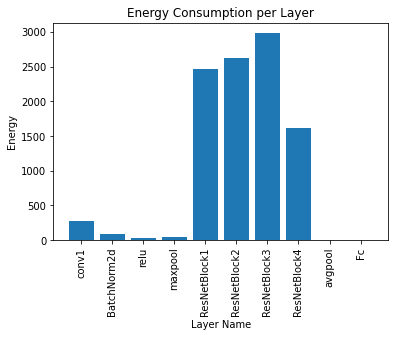

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(csv_file)

# Plot the values of energy in a bar plot
plt.bar(df['Layer Name'], df['Energy(mJ)'])
plt.xlabel('Layer Name')
plt.ylabel('Energy')
plt.title('Energy Consumption per Layer')
plt.xticks(rotation=90)
plt.show()

# VGG 16


In [1]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np


class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [3]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements

import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements


import torch.nn as nn
import torch.nn.functional as F


class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        #q = multiprocessing.Queue()
        #q.put('start')
        #p = multiprocessing.Process(target=measure, args=(q,))
        #p.start()
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        # Signal the end of the measurement
        #q.put('stop')
        # Wait for the measurement to finish
        #p.join()
        # Retrieve the power measurements from the queue
       # while not q.empty():
           # power_output = q.get()
           # if power_output == 'stop':
            #    break
            #print(power_output)
        return out


def measure(q, rq, gpu_ids):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=1 -i {gpu_ids}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
#FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")
model = VGG16().to(device)
batch_size = 8
X = torch.randn(size=(batch_size, 3, 227, 227)).to(device)
model.train()
power_measurements = []
for i in range(30):
    # Start the power measurement
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue()
    

    # Signal the start of the measurement

    # Run the inference
    x = X.clone()
    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started' 
    x = model.layer1(x)

    x = model.layer2(x)

    x = model.layer3(x)

    x = model.layer4(x)

    x = model.layer5(x)

    x = model.layer6(x)

    x = model.layer7(x)

    x = model.layer8(x)

    x = model.layer9(x)

    
    x = model.layer10(x)


    x = model.layer11(x)

    x = model.layer12(x)

    x = model.layer13(x)


    x = x.reshape(x.size(0), -1)

    x = model.fc(x)

    x = model.fc1(x)

    x = model.fc2(x)
    q.put('stop')

    # Signal the end of the power measurement
    output = x

    # Wait for the measurement to finish
    p.join()

    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float
        
print(output.shape) 
mean_power = np.mean(power_measurements)
print("Mean power: ", mean_power)
percentile_90 = np.percentile(power_measurements, 90)
average_above_90th = np.mean(np.array(power_measurements)[np.array(power_measurements) >= percentile_90])
print('Average of values >= __th percentile:', average_above_90th)

use_cuda :  True
gotstarted
58.34 W
gotstarted
127.81 W
gotstarted
118.93 W
gotstarted
119.62 W
gotstarted
114.84 W
gotstarted
116.45 W
gotstarted
106.24 W
gotstarted
117.42 W
gotstarted
128.70 W
gotstarted
118.69 W
gotstarted
118.60 W
gotstarted
107.84 W
gotstarted
109.24 W
gotstarted
117.98 W
gotstarted
117.51 W
gotstarted
118.40 W
gotstarted
116.60 W
gotstarted
113.93 W
gotstarted
118.99 W
gotstarted
122.72 W
gotstarted
126.30 W
gotstarted
123.43 W
gotstarted
106.20 W
gotstarted
125.36 W
gotstarted
122.31 W
gotstarted
116.95 W
gotstarted
118.69 W
gotstarted
107.71 W
gotstarted
118.77 W
gotstarted
107.50 W
torch.Size([8, 10])
Mean power:  115.40233333333332
Average of values >= __th percentile: 127.60333333333334


## multiprocess

In [3]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements

import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements


import torch.nn as nn
import torch.nn.functional as F


class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        #q = multiprocessing.Queue()
        #q.put('start')
        #p = multiprocessing.Process(target=measure, args=(q,))
        #p.start()
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        # Signal the end of the measurement
        #q.put('stop')
        # Wait for the measurement to finish
        #p.join()
        # Retrieve the power measurements from the queue
       # while not q.empty():
           # power_output = q.get()
           # if power_output == 'stop':
            #    break
            #print(power_output)
        return out


def measure(q, rq, gpu_ids):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=1 -i {gpu_ids}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
#FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")
model = VGG16().to(device)
batch_size = 8
X = torch.randn(size=(batch_size, 3, 227, 227)).to(device)
model.train()
power_measurements =[] 
power_measurements = [] 
power_measurements1 = []
power_measurements2 = []
power_measurements3 = []
power_measurements4 = []
power_measurements5 = []
power_measurements6 = []
power_measurements7 = []
power_measurements8 = [] 
power_measurements9 = []
power_measurements10 = [] 
power_measurements11 = []
power_measurements12 = []
power_measurements13 = []
power_measurements14 = []
power_measurements15 = []

for i in range(10):
    # Start the power measurement
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue()
    q1 = multiprocessing.Queue()
    rq1 = multiprocessing.Queue()
    q2 = multiprocessing.Queue()
    rq2 = multiprocessing.Queue()
    q3 = multiprocessing.Queue()
    rq3 = multiprocessing.Queue()
    q4 = multiprocessing.Queue()
    rq4 = multiprocessing.Queue() 
    rq5 = multiprocessing.Queue()
    q5 = multiprocessing.Queue()
    rq6 = multiprocessing.Queue()
    q6 = multiprocessing.Queue()
    q7 = multiprocessing.Queue()
    rq7 = multiprocessing.Queue() 
    q8 = multiprocessing.Queue()
    rq8 = multiprocessing.Queue() 
    q9 = multiprocessing.Queue()
    rq9 = multiprocessing.Queue()  
    q10 = multiprocessing.Queue()
    rq10 = multiprocessing.Queue() 
    rq11 = multiprocessing.Queue()
    q11 = multiprocessing.Queue()
    rq12 = multiprocessing.Queue()
    q12 = multiprocessing.Queue()
    rq13 = multiprocessing.Queue()
    q13 = multiprocessing.Queue()
    rq14 = multiprocessing.Queue() 
    q14 = multiprocessing.Queue()
    rq15 = multiprocessing.Queue() 
    q15 = multiprocessing.Queue()


    # Signal the start of the measurement

    # Run the inference
    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started' 
    x = X.clone()
    for i in range(10):
        x1 = model.layer1(x)
    q.put('stop')

    
    p1 = multiprocessing.Process(target=measure, args=(q1,rq1,1))
    p1.start()
    q1.put('start')
    m = rq1.get()
    print('got' + m)
    assert m == 'started'               
    for i in range(10):
        x2 = model.layer2(x1)
    q1.put('stop')
    
    
    p2 = multiprocessing.Process(target=measure, args=(q2,rq2,1))
    p2.start()
    q2.put('start')
    m = rq2.get()
    print('got' + m)
    assert m == 'started'              
    for i in range(10):
        x3 = model.layer3(x2)
    q2.put('stop')
    
    
            
        
    p3 = multiprocessing.Process(target=measure, args=(q3,rq3,1))
    p3.start()
    q3.put('start')
    m = rq3.get()
    print('got' + m)
    assert m == 'started'          
    for i in range(10):
        x4 = model.layer4(x3)        
    q3.put('stop')
    



    p4 = multiprocessing.Process(target=measure, args=(q4,rq4,1))
    p4.start()
    q4.put('start')
    m = rq4.get()
    print('got' + m)
    assert m == 'started'          
    for i in range(10):
        x5 = model.layer5(x4)
    q4.put('stop')
    
    
    
    p5 = multiprocessing.Process(target=measure, args=(q5,rq5,1))
    p5.start()
    q5.put('start')
    m = rq5.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        x6 = model.layer6(x5)        
    q5.put('stop')
    
    #x = model.maxpool(x)
    p6 = multiprocessing.Process(target=measure, args=(q6,rq6,1))
    p6.start()
    q6.put('start')
    m = rq6.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        x7 = model.layer7(x6)        
    q6.put('stop')


    p7 = multiprocessing.Process(target=measure, args=(q7,rq7,1))
    p7.start()
    q7.put('start')
    m = rq7.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        x8 = model.layer8(x7)            
    q7.put('stop')




    p8 = multiprocessing.Process(target=measure, args=(q8,rq8,1))
    p8.start()
    q8.put('start')
    m = rq8.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        x9 = model.layer9(x8)            
    q8.put('stop')

    # Signal the end of the power measurement
    #output = model.forward(X)   


    p9 = multiprocessing.Process(target=measure, args=(q9,rq9,1))
    p9.start()
    q9.put('start')
    m = rq9.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        x10 = model.layer10(x9)    
    q9.put('stop') 

    p10 = multiprocessing.Process(target=measure, args=(q10,rq10,1))
    p10.start()
    q10.put('start')
    m = rq10.get()
    print('got' + m)
    assert m == 'started'          
    for i in range(10):
        x11 = model.layer11(x10)    
    q10.put('stop')
    
    
    
    p11 = multiprocessing.Process(target=measure, args=(q11,rq11,1))
    p11.start()
    q11.put('start')
    m = rq11.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        x12 = model.layer12(x11)    
    q11.put('stop')
    
    #x = model.maxpool(x)
    p12 = multiprocessing.Process(target=measure, args=(q12,rq12,1))
    p12.start()
    q12.put('start')
    m = rq12.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        x13 = model.layer13(x12)    
    q12.put('stop')


    p13 = multiprocessing.Process(target=measure, args=(q13,rq13,1))
    p13.start()
    q13.put('start')
    m = rq13.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        x14 = x13.reshape(x13.size(0), -1)
        x14 = model.fc(x14)
    q13.put('stop')




    p14 = multiprocessing.Process(target=measure, args=(q14,rq14,1))
    p14.start()
    q14.put('start')
    m = rq14.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10): 
        x15 = model.fc1(x14)
    q14.put('stop')

    # Signal the end of the power measurement
    #output = model.forward(X)   


    p15 = multiprocessing.Process(target=measure, args=(q15,rq15,1))
    p15.start()
    q15.put('start')
    m = rq15.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10): 
        x16 = model.fc2(x15)
    q15.put('stop')


    output = x16


    # Signal the start of the measurement

    # Run the inference

    # Signal the end of the power measurement



    # Wait for the measurement to finish
    p.join() 
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
    p6.join()
    p7.join()
    p8.join() 
    p9.join() 
    p10.join() 
    p11.join()
    p12.join()
    p13.join()
    p14.join()
    p15.join()



    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq1.empty():
        power_output = rq1.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements1.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq2.empty():
        power_output = rq2.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements2.append(float(power_output.split()[0]))  # Remov] 


    # Retrieve the power measurements from the queue
    while not rq3.empty():
        power_output = rq3.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements3.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq4.empty():
        power_output = rq4.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements4.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq5.empty():
        power_output = rq5.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements5.append(float(power_output.split()[0]))  # Remov] 

    # Retrieve the power measurements from the queue
    while not rq6.empty():
        power_output = rq6.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements6.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq7.empty():
        power_output = rq7.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements7.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq8.empty():
        power_output = rq8.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements8.append(float(power_output.split()[0]))  # Remov] 


    while not rq9.empty():
        power_output = rq9.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements9.append(float(power_output.split()[0]))  # Remov]

    # Retrieve the power measurements from the queue
    while not rq10.empty():
        power_output = rq10.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements10.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq11.empty():
        power_output = rq11.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements11.append(float(power_output.split()[0]))  # Remov] 

    # Retrieve the power measurements from the queue
    while not rq12.empty():
        power_output = rq12.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements12.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq13.empty():
        power_output = rq13.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements13.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq14.empty():
        power_output = rq14.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements14.append(float(power_output.split()[0]))  # Remov]  

    while not rq15.empty():
        power_output = rq15.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements15.append(float(power_output.split()[0]))  # Remov] 



print(output.shape) 
mean_power = np.mean(power_measurements)
print("Mean power: ", mean_power)
mean_power1 = np.mean(power_measurements1)
print("Mean power1: ", mean_power1) 
mean_power2 = np.mean(power_measurements2)
print("Mean power2: ", mean_power2)
mean_power3 = np.mean(power_measurements3)
print("Mean power3: ", mean_power3) 
mean_power4 = np.mean(power_measurements4)
print("Mean power4: ", mean_power4) 
mean_power5 = np.mean(power_measurements5)
print("Mean power5: ", mean_power5) 
mean_power6 = np.mean(power_measurements6)
print("Mean power6: ", mean_power6)
mean_power7 = np.mean(power_measurements7)
print("Mean power7: ", mean_power7) 
mean_power8 = np.mean(power_measurements8)
print("Mean power8: ", mean_power8) 
mean_power9 = np.mean(power_measurements9)
print("Mean power9: ", mean_power9) 
mean_power10 = np.mean(power_measurements10)
print("Mean power10: ", mean_power10)
mean_power11 = np.mean(power_measurements11)
print("Mean power11: ", mean_power11) 
mean_power12 = np.mean(power_measurements12)
print("Mean power12: ", mean_power12) 
mean_power13 = np.mean(power_measurements13)
print("Mean power13: ", mean_power13)
mean_power14 = np.mean(power_measurements14)
print("Mean power14: ", mean_power14) 
mean_power15 = np.mean(power_measurements15)
print("Mean power15: ", mean_power15)


use_cuda :  True
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
89.88 W
111.72 W
153.98 W
196.10 W
161.53 W
164.14 W
173.21 W
166.65 W
175.15 W
164.47 W
150.94 W
149.29 W
148.57 W
109.36 W
56.33 W
46.37 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
106.47 W
134.72 W
180.70 W
213.21 W
164.53 W
60.57 W
169.68 W
163.84 W
194.01 W
177.06 W
152.06 W
147.83 W
149.75 W
108.13 W
55.50 W
46.61 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
106.83 W
134.12 W
191.50 W
197.00 W
172.17 W
173.59 W
173.35 W
168.29 W
178.62 W
173.19 W
149.79 W
147.85 W
152.27 W
109.46 W
54.79 W
46.66 W
gotstarted
gotstarted
gotstarte

In [4]:
import torch
import torch.nn as nn
import time as timer_l
import pandas as pd
import numpy as np
#from numba import cuda
#import matplotlib.pyplot as plt
import re

class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        with torch.autograd.profiler.record_function("layer1"):
            out = self.layer1(x)
        with torch.autograd.profiler.record_function("layer2"):
            out = self.layer2(out)
        with torch.autograd.profiler.record_function("layer3"):
            out = self.layer3(out)
        with torch.autograd.profiler.record_function("layer4"):
            out = self.layer4(out)
        with torch.autograd.profiler.record_function("layer5"):
            out = self.layer5(out)
        with torch.autograd.profiler.record_function("layer6"):
            out = self.layer6(out)
        with torch.autograd.profiler.record_function("layer7"):
            out = self.layer7(out)
        with torch.autograd.profiler.record_function("layer8"):
            out = self.layer8(out)
        with torch.autograd.profiler.record_function("layer9"):
            out = self.layer9(out)
        with torch.autograd.profiler.record_function("layer10"):
            out = self.layer10(out)
        with torch.autograd.profiler.record_function("layer11"):
            out = self.layer11(out)
        with torch.autograd.profiler.record_function("layer12"):
            out = self.layer12(out)
        with torch.autograd.profiler.record_function("layer13"):
            out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        with torch.autograd.profiler.record_function("FC"):
            out = self.fc(out)
        with torch.autograd.profiler.record_function("FC1"):
            out = self.fc1(out)
        with torch.autograd.profiler.record_function("FC2"):
            out = self.fc2(out)
        return out

use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
#FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device= torch.device("cuda:0" if use_cuda else "cpu")
model = VGG16().to(device)    
batch_size = 8
X = torch.randn(size=(batch_size, 3, 227, 227)).to(device) 

# Run the model and record the inference time of each layer
for i in range(10):
    profiler = torch.autograd.profiler.profile(enabled=True, use_cuda=True, record_shapes=True)
    model.forward(X)
    with profiler:
        output = model.forward(X)

# Get the table of profiling results
profiling_results2 = profiler.key_averages().table()
print(profiling_results2) 


use_cuda :  True


STAGE:2023-05-31 11:26:29 59794:59794 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 11:26:29 59794:59794 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 11:26:29 59794:59794 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 11:26:29 59794:59794 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 11:26:29 59794:59794 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 11:26:29 59794:59794 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 11:26:29 59794:59794 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 11:26:29 59794:59794 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 11:26:29 59794:59794 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 11:26:29 59794:59794 ActivityProfilerController.cpp:311] Co

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 layer1         0.43%     151.000us         1.41%     493.000us     493.000us      11.000us         0.05%       1.508ms       1.508ms             1  
                                           aten::conv2d         0.38%     132.000us         4.72%       1.644ms     126.462us      51.000us         0.25%      14.632ms       1.126ms            13  
         

## Table 

In [ ]:
import csv
import re
import pandas as pd

# Split the profiler table into lines
lines = profiling_results2.strip().split('\n')

# Define the layer names
layer_names = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8', 'layer9', 'layer10','layer11','layer12','layer13','FC','FC1','FC2']
power_measurements = [mean_power, mean_power1, mean_power2, mean_power3, mean_power4, mean_power5, mean_power6, mean_power7, mean_power8,mean_power9, mean_power10, mean_power11, mean_power12,mean_power13,mean_power14,mean_power15]

# Extract the 'CUDA time avg' values for the specified layers
cuda_time_avgs = {}
for layer_name in layer_names:
    layer_line = next(line for line in lines if layer_name in line)
    cuda_time_avg_us = re.findall(r'\d+\.\d+(?:us|ms)', layer_line)[-1]
    cuda_time_avg_ms = float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0]) / 1000 if 'us' in cuda_time_avg_us else float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0])
    cuda_time_avgs[layer_name] = cuda_time_avg_ms

# Calculate the energy by multiplying CUDA time avg and power measurements
energy_values = [cuda_time_avgs[layer_name] * power_measurements[i] for i, layer_name in enumerate(layer_names)]

# Save the results in a CSV file
csv_file3 = 'profiler_results_VGG16.csv'
with open(csv_file3, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Layer Name', 'CUDA Time Avg (ms)', 'Power Measurements(W)', 'Energy(mJ)'])
    for i, layer_name in enumerate(layer_names):
        writer.writerow([layer_name, cuda_time_avgs[layer_name], power_measurements[i], energy_values[i]])

print(f"Profiler results saved in '{csv_file3}'.")

# Read the CSV file
df3 = pd.read_csv(csv_file3)

# Display the table
print(df3)


Profiler results saved in 'profiler_results_VGG16.csv'.
   Layer Name  CUDA Time Avg (ms)  Power Measurements(W)  Energy(mJ)
0      layer1               3.176                 38.784  123.177984
1      layer2               6.956                 38.852  270.254512
2      layer3               3.265                 38.832  126.786480
3      layer4               4.058                 39.519  160.368102
4      layer5               1.523                 38.745   59.008635
5      layer6               2.196                 39.691   87.161436
6      layer7               2.318                146.362  339.267116
7      layer8               1.177                143.792  169.243184
8      layer9               1.859                164.232  305.307288
9     layer10               1.927                159.023  306.437321
10    layer11               0.696                 89.409   62.228664
11    layer12               0.696                 90.742   63.156432
12    layer13               0.717              

In [ ]:
import pandas as pd

# Calculate the sum of energy for all layers
total_energy = df3['Energy(mJ)'].sum()

# Extract the self CUDA time from the profiling results
self_cuda_time = self_cuda_time_total
power_idle = 38
# Multiply self CUDA time by X (adjust the value of X according to your needs)
X =average_above_90th - power_idle
result = self_cuda_time * X

# Create a new DataFrame with two columns
new_df = pd.DataFrame({'Sum of Energy': [total_energy], 'Self CUDA Time * X': [result]})

display(new_df)

## Bar Plots

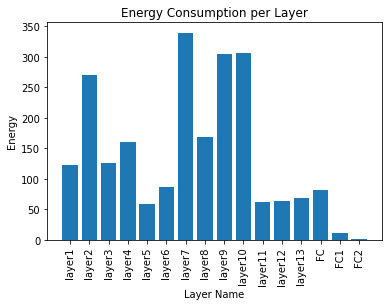

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df3 = pd.read_csv(csv_file3)

# Plot the values of energy in a bar plot
plt.bar(df3['Layer Name'], df3['Energy(mJ)'])
plt.xlabel('Layer Name')
plt.ylabel('Energy')
plt.title('Energy Consumption per Layer')
plt.xticks(rotation=90)
plt.show()

# EfficientNet_B0

In [ ]:
#!pip install validators matplotlib
#efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
#utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable
  Created wheel for validators: filename=validators-0.14.2-py2-none-any.whl size=17491 sha256=801fe0acdb901378b2a400d8796e26857e47cae223913627881b5b0a9d4aaf33
  Stored in directory: /home/daouda/.cache/pip/wheels/e2/6d/bc/878f25fb3f7a9ec6e473a9b30698f0c734c5ed7e9816c47cd5
Successfully built validators
You should consider upgrading via the '/usr/bin

/home/daouda/.local/lib/python3.8/site-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /home/daouda/.cache/torch/hub/torchhub.zip
/home/daouda/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be ava

ModuleNotFoundError: No module named 'validators'

In [ ]:
efficientnet.eval()

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio):
        super(MBConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.expand_ratio = expand_ratio
        self.se_ratio = se_ratio

        # Expansion phase
        self.expand = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * expand_ratio, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * expand_ratio),
            nn.ReLU6(inplace=True)
        )

        # Depthwise convolution phase
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels * expand_ratio, in_channels * expand_ratio, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2, groups=in_channels * expand_ratio, bias=False),
            nn.BatchNorm2d(in_channels * expand_ratio),
            nn.ReLU6(inplace=True)
        )

        # Squeeze-and-excitation phase
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * expand_ratio, in_channels * expand_ratio // se_ratio, kernel_size=1, stride=1,
                      padding=0, bias=False),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels * expand_ratio // se_ratio, in_channels * expand_ratio, kernel_size=1, stride=1,
                      padding=0, bias=False),
            nn.Sigmoid()
        )

        # Output phase
        self.project = nn.Sequential(
            nn.Conv2d(in_channels * expand_ratio, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Skip connection phase
        self.use_skip = (stride == 1 and in_channels == out_channels)
        if self.use_skip:
            self.skip = nn.Identity()

    def forward(self, x):
        out = self.expand(x)
        out = self.conv(out)
        out = self.se(out) * out
        out = self.project(out)

        if self.use_skip:
            out = out + self.skip(x)

        return out


class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1000):
        super(EfficientNetB0, self).__init__()
        self.num_classes = num_classes

        # Stem convolution
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        # MBConv blocks
        self.block1 = nn.Sequential(MBConvBlock(32, 16, kernel_size=3, stride=1, expand_ratio=1, se_ratio=4),
            MBConvBlock(16, 24, kernel_size=3, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(24, 24, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(24, 40, kernel_size=5, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(40, 40, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4))
        self.block2 = nn.Sequential(MBConvBlock(40, 80, kernel_size=3, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(80, 80, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(80, 112, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(112, 112, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4))
        self.block3 = nn.Sequential(MBConvBlock(112, 192, kernel_size=5, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(192, 320, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4)
        )

        # Head convolution
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, num_classes, bias=True)
        )

    def forward(self, x):
        out = self.stem(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.head(out)
        out = self.classifier(out)

        return out 


In [12]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements


import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F


class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio):
        super(MBConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.expand_ratio = expand_ratio
        self.se_ratio = se_ratio

        # Expansion phase
        self.expand = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * expand_ratio, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * expand_ratio),
            nn.ReLU6(inplace=True)
        )

        # Depthwise convolution phase
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels * expand_ratio, in_channels * expand_ratio, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2, groups=in_channels * expand_ratio, bias=False),
            nn.BatchNorm2d(in_channels * expand_ratio),
            nn.ReLU6(inplace=True)
        )

        # Squeeze-and-excitation phase
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * expand_ratio, in_channels * expand_ratio // se_ratio, kernel_size=1, stride=1,
                      padding=0, bias=False),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels * expand_ratio // se_ratio, in_channels * expand_ratio, kernel_size=1, stride=1,
                      padding=0, bias=False),
            nn.Sigmoid()
        )

        # Output phase
        self.project = nn.Sequential(
            nn.Conv2d(in_channels * expand_ratio, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Skip connection phase
        self.use_skip = (stride == 1 and in_channels == out_channels)
        if self.use_skip:
            self.skip = nn.Identity()

    def forward(self, x):
        out = self.expand(x)
        out = self.conv(out)
        out = self.se(out) * out
        out = self.project(out)

        if self.use_skip:
            out = out + self.skip(x)

        return out

class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1000):
        super(EfficientNetB0, self).__init__()
        self.num_classes = num_classes

        # Stem convolution
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        # MBConv blocks
        self.block1 = nn.Sequential(MBConvBlock(32, 16, kernel_size=3, stride=1, expand_ratio=1, se_ratio=4),
            MBConvBlock(16, 24, kernel_size=3, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(24, 24, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(24, 40, kernel_size=5, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(40, 40, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4))
        self.block2 = nn.Sequential(MBConvBlock(40, 80, kernel_size=3, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(80, 80, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(80, 112, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(112, 112, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4))
        self.block3 = nn.Sequential(MBConvBlock(112, 192, kernel_size=5, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(192, 320, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4)
        )

        # Head convolution
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, num_classes, bias=True)
        )

    def forward(self, x):
        out = self.stem(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.head(out)
        out = self.classifier(out)

        return out

def measure(q, rq, gpu_id):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=2 -i {gpu_id}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")
model = EfficientNetB0().to(device)
batch_size = 8
X= torch.randn(size=(batch_size, 3, 224, 224)).type(FloatTensor).to(device)
model.train()
power_measurements = []

for i in range(20):
    # Start the power measurement
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue()
    

    # Signal the start of the measurement

    # Run the inference########################
    #output = model.forward(X)
    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started'          
    x = X.clone()
    x = model.stem(x)

    

    x = model.block1(x)
            

    
    x = model.block2(x)

    

    x = model.block3(x)
    
    x = model.head(x)

    
    x = model.classifier(x)

    output = x
    q.put('stop')

    
    #################

    # Wait for the measurement to finish
    p.join()

    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float
        
print(output.shape) 
mean_power_1 = np.mean(power_measurements)
print("Mean power0: ", mean_power_1)
percentile_90 = np.percentile(power_measurements, 90)
average_above_90th = np.mean(np.array(power_measurements)[np.array(power_measurements) >= percentile_90])
print('Average of values >= __th percentile:', average_above_90th)

use_cuda :  True
gotstarted
39.96 W
gotstarted
51.61 W
gotstarted
51.79 W
gotstarted
52.37 W
gotstarted
50.54 W
gotstarted
51.61 W
gotstarted
50.12 W
gotstarted
48.10 W
gotstarted
51.97 W
gotstarted
50.25 W
gotstarted
50.73 W
gotstarted
50.73 W
gotstarted
51.79 W
gotstarted
52.87 W
gotstarted
49.27 W
gotstarted
51.02 W
gotstarted
49.07 W
gotstarted
49.39 W
gotstarted
51.29 W
gotstarted
51.00 W
torch.Size([8, 1000])
Mean power0:  50.274
Average of values >= __th percentile: 52.62


## Multiprocess_power measurement Efficient NetB0

In [20]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements


import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F


class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio):
        super(MBConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.expand_ratio = expand_ratio
        self.se_ratio = se_ratio

        # Expansion phase
        self.expand = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * expand_ratio, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * expand_ratio),
            nn.ReLU6(inplace=True)
        )

        # Depthwise convolution phase
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels * expand_ratio, in_channels * expand_ratio, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2, groups=in_channels * expand_ratio, bias=False),
            nn.BatchNorm2d(in_channels * expand_ratio),
            nn.ReLU6(inplace=True)
        )

        # Squeeze-and-excitation phase
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * expand_ratio, in_channels * expand_ratio // se_ratio, kernel_size=1, stride=1,
                      padding=0, bias=False),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels * expand_ratio // se_ratio, in_channels * expand_ratio, kernel_size=1, stride=1,
                      padding=0, bias=False),
            nn.Sigmoid()
        )

        # Output phase
        self.project = nn.Sequential(
            nn.Conv2d(in_channels * expand_ratio, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Skip connection phase
        self.use_skip = (stride == 1 and in_channels == out_channels)
        if self.use_skip:
            self.skip = nn.Identity()

    def forward(self, x):
        out = self.expand(x)
        out = self.conv(out)
        out = self.se(out) * out
        out = self.project(out)

        if self.use_skip:
            out = out + self.skip(x)

        return out

class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1000):
        super(EfficientNetB0, self).__init__()
        self.num_classes = num_classes

        # Stem convolution
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        # MBConv blocks
        self.block1 = nn.Sequential(MBConvBlock(32, 16, kernel_size=3, stride=1, expand_ratio=1, se_ratio=4),
            MBConvBlock(16, 24, kernel_size=3, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(24, 24, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(24, 40, kernel_size=5, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(40, 40, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4))
        self.block2 = nn.Sequential(MBConvBlock(40, 80, kernel_size=3, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(80, 80, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(80, 112, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(112, 112, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4))
        self.block3 = nn.Sequential(MBConvBlock(112, 192, kernel_size=5, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(192, 320, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4)
        )

        # Head convolution
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, num_classes, bias=True)
        )

    def forward(self, x):
        out = self.stem(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.head(out)
        out = self.classifier(out)

        return out

def measure(q, rq, gpu_id):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=2 -i {gpu_id}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")
model = EfficientNetB0().to(device)
batch_size = 8
X= torch.randn(size=(batch_size, 3, 224, 224)).type(FloatTensor).to(device)
model.train()
power_measurements = [] 
power_measurements1 = []
power_measurements2 = []
power_measurements3 = []
power_measurements4 = []
power_measurements5 = []

for i in range(10):
    # Start the power measurement
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue()
    q1 = multiprocessing.Queue()
    rq1 = multiprocessing.Queue()
    q2 = multiprocessing.Queue()
    rq2 = multiprocessing.Queue()
    q3 = multiprocessing.Queue()
    rq3 = multiprocessing.Queue()
    q4 = multiprocessing.Queue()
    rq4 = multiprocessing.Queue() 
    q5 = multiprocessing.Queue()
    rq5 = multiprocessing.Queue()
    
    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started' 
    x = X.clone()
    for i in range(10):
        x1 = model.stem(x)
    q.put('stop')
    p.join() 
    
    p1 = multiprocessing.Process(target=measure, args=(q1,rq1,1))
    p1.start()
    q1.put('start')
    m = rq1.get()
    print('got' + m)
    assert m == 'started'               
    #x = model.maxpool(x)
    for i in range(100):
        x2 = model.block1(x1)
    q1.put('stop')
    p1.join()
    
    
    p2 = multiprocessing.Process(target=measure, args=(q2,rq2,1))
    p2.start()
    q2.put('start')
    m = rq2.get()
    print('got' + m)
    assert m == 'started'              
    #x = model.maxpool(x)
    for i in range(10):

        x3= model.block2(x2)
    q2.put('stop')
    p2.join()
    
            
        
    p3 = multiprocessing.Process(target=measure, args=(q3,rq3,1))
    p3.start()
    q3.put('start')
    m = rq3.get()
    print('got' + m)
    assert m == 'started'  
    for i in range(10):
        x4 = model.block3(x3)
    q3.put('stop')
    p3.join()       



    p4 = multiprocessing.Process(target=measure, args=(q4,rq4,1))
    p4.start()
    q4.put('start')
    m = rq4.get()
    print('got' + m)
    assert m == 'started' 
    for i in range(10):
        x5 = model.head(x4)
    q4.put('stop')
    p4.join()        
    
    p5 = multiprocessing.Process(target=measure, args=(q5,rq5,1))
    p5.start()
    q5.put('start')
    m = rq5.get()
    print('got' + m)
    assert m == 'started'
    for i in range(10):
        x6 = model.classifier(x5)
    q5.put('stop')

    p5.join()
    # Run the inference########################
    #output = model.forward(X)

    output = x6


    

            

    



    
    #################

    # Wait for the measurement to finish





    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq1.empty():
        power_output = rq1.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements1.append(float(power_output.split()[0]))  # Remov


    # Retrieve the power measurements from the queue
    while not rq2.empty():
        power_output = rq2.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements2.append(float(power_output.split()[0]))  # Remov] 


    # Retrieve the power measurements from the queue
    while not rq3.empty():
        power_output = rq3.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements3.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq4.empty():
        power_output = rq4.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements4.append(float(power_output.split()[0]))  # Remov
            
    # Retrieve the power measurements from the queue
    while not rq5.empty():
        power_output = rq5.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements5.append(float(power_output.split()[0]))  # Remov
        


print(output.shape) 
mean_power = np.mean(power_measurements)
print("stem power: ", mean_power) 
mean_power1 = np.mean(power_measurements1)
print("block1 power: ", mean_power1)
mean_power2= np.mean(power_measurements2)
print("block2 power: ", mean_power2)
mean_power3 = np.mean(power_measurements3)
print("block3 power: ", mean_power3)
mean_power4 = np.mean(power_measurements4)
print("head power: ", mean_power4)
mean_power5 = np.mean(power_measurements5)
print("classifier power: ", mean_power5)

use_cuda :  True
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
45.49 W
50.82 W
50.32 W
48.29 W
48.88 W
46.27 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
55.67 W
56.07 W
51.51 W
51.02 W
49.47 W
46.46 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
54.44 W
54.89 W
51.90 W
51.48 W
49.77 W
46.37 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
51.59 W
54.99 W
51.20 W
50.44 W
49.65 W
46.46 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
52.97 W
58.38 W
48.97 W
48.98 W
50.63 W
46.36 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
52.76 W
58.74 W
51.30 W
47.24 W
49.96 W
46.45 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
54.99 W
58.59 W
50.15 W
50.84 W
49.56 W
46.66 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
53.83 W
56.65 W
50.92 W
51.32 W
49.56 W
46.56 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
53.55

In [14]:
##### import torch
import torch

import torch.nn as nn
import time as timer_l
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio):
        super(MBConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.expand_ratio = expand_ratio
        self.se_ratio = se_ratio

        # Expansion phase
        self.expand = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * expand_ratio, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * expand_ratio),
            nn.ReLU6(inplace=True)
        )

        # Depthwise convolution phase
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels * expand_ratio, in_channels * expand_ratio, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2, groups=in_channels * expand_ratio, bias=False),
            nn.BatchNorm2d(in_channels * expand_ratio),
            nn.ReLU6(inplace=True)
        )

        # Squeeze-and-excitation phase
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels * expand_ratio, in_channels * expand_ratio // se_ratio, kernel_size=1, stride=1,
                      padding=0, bias=False),
            nn.ReLU6(inplace=True),
            nn.Conv2d(in_channels * expand_ratio // se_ratio, in_channels * expand_ratio, kernel_size=1, stride=1,
                      padding=0, bias=False),
            nn.Sigmoid()
        )

        # Output phase
        self.project = nn.Sequential(
            nn.Conv2d(in_channels * expand_ratio, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # Skip connection phase
        self.use_skip = (stride == 1 and in_channels == out_channels)
        if self.use_skip:
            self.skip = nn.Identity()

    def forward(self, x):
        out = self.expand(x)
        out = self.conv(out)
        out = self.se(out) * out
        out = self.project(out)

        if self.use_skip:
            out = out + self.skip(x)

        return out


class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1000):
        super(EfficientNetB0, self).__init__()
        self.num_classes = num_classes

        # Stem convolution
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        # MBConv blocks
        self.block1 = nn.Sequential(MBConvBlock(32, 16, kernel_size=3, stride=1, expand_ratio=1, se_ratio=4),
            MBConvBlock(16, 24, kernel_size=3, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(24, 24, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(24, 40, kernel_size=5, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(40, 40, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4))
        self.block2 = nn.Sequential(MBConvBlock(40, 80, kernel_size=3, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(80, 80, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(80, 112, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(112, 112, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4))
        self.block3 = nn.Sequential(MBConvBlock(112, 192, kernel_size=5, stride=2, expand_ratio=6, se_ratio=4),
            MBConvBlock(192, 192, kernel_size=5, stride=1, expand_ratio=6, se_ratio=4),
            MBConvBlock(192, 320, kernel_size=3, stride=1, expand_ratio=6, se_ratio=4)
        )

        # Head convolution
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, num_classes, bias=True)
        )

    def forward(self, x):
        with torch.autograd.profiler.record_function("Stem"):
            out = self.stem(x)
        with torch.autograd.profiler.record_function("block1"):
            out = self.block1(out)
        with torch.autograd.profiler.record_function("block2"):
            out = self.block2(out)
        with torch.autograd.profiler.record_function("block3"):
            out = self.block3(out)
        with torch.autograd.profiler.record_function("head"):
            out = self.head(out)
        with torch.autograd.profiler.record_function("classifier"):
            out = self.classifier(out)

        return out

use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
print(torch.cuda.get_device_name(0))

#FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device= torch.device("cuda:0" if use_cuda else "cpu")
model = EfficientNetB0().to(device)    
batch_size = 8
X = torch.randn(size=(batch_size, 3, 227, 227)).to(device) 

# Run the model and record the inference time of each layer
for i in range(10):
    profiler = torch.autograd.profiler.profile(enabled=True, use_cuda=True, record_shapes=True) 
    model.forward(X) #warm up
    with profiler:
        output = model.forward(X)

# Get the table of profiling results
profiling_results4 = profiler.key_averages().table()
print(profiling_results4)


use_cuda :  True
Tesla V100-PCIE-32GB


STAGE:2023-05-31 11:56:54 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 11:56:54 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 11:56:54 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 11:56:54 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 11:56:54 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 11:56:54 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 11:56:54 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 11:56:54 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 11:56:54 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 11:56:54 63839:63839 ActivityProfilerController.cpp:311] Co

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Stem         0.74%     153.000us         2.53%     526.000us     526.000us      89.000us         0.43%     592.000us     592.000us             1  
                                           aten::conv2d         3.24%     672.000us        24.14%       5.010ms      80.806us     532.000us         2.56%       6.311ms     101.790us            62  
         

## Table

In [8]:
# Find the index of "Self CUDA time total"
start_index = profiling_results4.find("Self CUDA time total: ")
if start_index != -1:
    # Extract the substring starting from the index of the value
    start_index += len("Self CUDA time total: ")
    end_index = profiling_results4.find("ms", start_index)
    if end_index != -1:
        # Extract the value as a float
        self_cuda_time_total = float(profiling_results4[start_index:end_index].strip())
        print( self_cuda_time_total, "ms")

21.609 ms


In [21]:
import csv
import re
import pandas as pd

# Split the profiler table into lines
lines = profiling_results4.strip().split('\n')

# Define the layer names
layer_names = ['Stem','block1','block2','block3','head','classifier']
power_measurements = [mean_power, mean_power1, mean_power2, mean_power3, mean_power4, mean_power5]

# Extract the 'CUDA time avg' values for the specified layers
cuda_time_avgs = {}
for layer_name in layer_names:
    layer_line = next(line for line in lines if layer_name in line)
    cuda_time_avg_us = re.findall(r'\d+\.\d+(?:us|ms)', layer_line)[-1]
    cuda_time_avg_ms = float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0]) / 1000 if 'us' in cuda_time_avg_us else float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0])
    cuda_time_avgs[layer_name] = cuda_time_avg_ms

# Calculate the energy by multiplying CUDA time avg and power measurements
power_idle = 38 #depends on the gpu
power_measurements_kernel = [power_measurement - power_idle for power_measurement in power_measurements]

# Calculate the energy by multiplying CUDA time avg and power measurements
energy_values = [cuda_time_avgs[layer_name] * power_measurements_kernel[i] for i, layer_name in enumerate(layer_names)]

# Save the results in a CSV file
csv_file4 = 'profiler_results_EfficientNetB0.csv'
with open(csv_file4, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Layer Name', 'CUDA Time Avg (ms)', 'Power Measurements(W)', 'Energy(mJ)'])
    for i, layer_name in enumerate(layer_names):
        writer.writerow([layer_name, cuda_time_avgs[layer_name], power_measurements[i], energy_values[i]])

print(f"Profiler results saved in '{csv_file4}'.")

# Read the CSV file
df4 = pd.read_csv(csv_file4)

# Display the table
display(df4)



Profiler results saved in 'profiler_results_EfficientNetB0.csv'.


,Layer Name,CUDA Time Avg (ms),Power Measurements(W),Energy(mJ)
0,Stem,0.592,52.930,8.838560
1,block1,7.937,56.125,143.858125
2,block2,6.546,50.783,83.677518
3,block3,4.931,50.009,59.216379
4,head,0.477,49.632,5.548464
5,classifier,0.303,46.499,2.575197


In [22]:
import pandas as pd

# Calculate the sum of energy for all layers
total_energy = df4['Energy(mJ)'].sum()

# Extract the self CUDA time from the profiling results
self_cuda_time = self_cuda_time_total
power_idle = 38
# Multiply self CUDA time by X (adjust the value of X according to your needs)
X =average_above_90th - power_idle
result = self_cuda_time * X

# Create a new DataFrame with two columns
new_df = pd.DataFrame({'Sum of Energy': [total_energy], 'Self CUDA Time * X': [result]})

display(new_df)

,Sum of Energy,Self CUDA Time * X
0,303.714243,315.92358


## Bar Plot

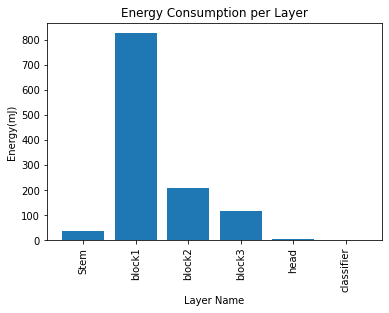

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(csv_file4)

# Plot the values of energy in a bar plot
plt.bar(df['Layer Name'], df['Energy(mJ)'])
plt.xlabel('Layer Name')
plt.ylabel('Energy(mJ)')
plt.title('Energy Consumption per Layer')
plt.xticks(rotation=90)
plt.show()

# GPT 2

In [ ]:
#!pip install transformers

Defaulting to user installation because normal site-packages is not writeable
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 737.9 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.15
    Uninstalling urllib3-1.26.15:
      Successfully uninstalled urllib3-1.26.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.7.1 requires importlib-resources>=3.2.0; python_version < "3.10", which is not installed.
spyder 4.1.5 requires pyqt5<5.13; python_version >= "3", which is not installed.
spyder 4.1.5 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
datasets 2.12.0 requires fsspec[http]>=2021.11.1, but you have fsspec 0.8.3 which is incompatible.
datasets 2.12.0 requires tqdm>=4.62.1, but you have tqdm 4.50.2 whic

In [23]:

import os
import sys
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

import torch 

# huggingface
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    GPT2Config,
)



/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# download model and tokernizer
GPT2_VARIANT = 'gpt2' # choices: gpt2 | gpt2-medium | gpt2-large | gpt2-xl
config = GPT2Config(GPT2_VARIANT)

model = GPT2LMHeadModel.from_pretrained(GPT2_VARIANT, force_download = False)
tokenizer = GPT2Tokenizer.from_pretrained(GPT2_VARIANT)


In [25]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [26]:
# save model locally
pytorch_model_dir = './models/{}/pytorch'.format(GPT2_VARIANT)
!mkdir -p $pytorch_model_dir

model.save_pretrained(pytorch_model_dir)
print("Pytorch Model saved to {}".format(pytorch_model_dir))

Pytorch Model saved to ./models/gpt2/pytorch


In [28]:

# carry out inference with a single sample
input_str = "Hello, my dog is "
inputs = tokenizer(input_str, return_tensors="pt")
input_ids = inputs.input_ids


In [29]:
model.eval()
with torch.no_grad():
    outputs = model(**inputs, labels=inputs['input_ids'], use_cache = False)
outputs
logits = outputs.logits
print(logits, logits.shape)

tensor([[[ -35.2362,  -35.3266,  -38.9753,  ...,  -44.4645,  -43.9974,
           -36.4580],
         [-112.6171, -114.5832, -116.5725,  ..., -119.0128, -118.8059,
          -111.6917],
         [ -88.7435,  -89.8644,  -93.1977,  ...,  -92.3839,  -96.1782,
           -92.1273],
         [ -85.1646,  -88.3380,  -92.8703,  ...,  -99.8017,  -94.7657,
           -90.9330],
         [-116.7281, -119.3950, -121.7259,  ..., -129.1003, -124.6102,
          -121.6092],
         [ -61.9848,  -63.7082,  -65.6898,  ...,  -76.0924,  -71.7897,
           -66.1154]]]) torch.Size([1, 6, 50257])


In [30]:
import torch
import torch.nn as nn
from torch.nn import Conv1d


class GPT2Attention(nn.Module):
    def __init__(self, n_embd, n_head, resid_pdrop, attn_pdrop):
        super().__init__()
        self.c_attn = Conv1d(n_embd, 3*n_embd, 1, bias=False)
        self.c_proj = Conv1d(n_embd, n_embd, 1, bias=False)
        self.attn_dropout = nn.Dropout(attn_pdrop)
        self.resid_dropout = nn.Dropout(resid_pdrop)
        self.n_head = n_head
        self.split_size = n_embd // n_head
        
    def split_heads(self, x):
        return x.view(x.size(0), self.n_head, self.split_size, -1).transpose(2, 3)
        
    def merge_heads(self, x):
        return x.transpose(2, 3).contiguous().view(x.size(0), -1, self.n_head * self.split_size)
        
    def forward(self, x):
        query, key, value = self.c_attn(x).chunk(3, dim=1)
        query = self.split_heads(query)
        key = self.split_heads(key)
        value = self.split_heads(value)
        
        attn_weights = torch.matmul(query, key.transpose(-2, -1))
        attn_weights = attn_weights / (self.split_size ** 0.5)
        attn_weights = nn.Softmax(dim=-1)(attn_weights)
        attn_weights = self.attn_dropout(attn_weights)
        attn_output = torch.matmul(attn_weights, value)
        attn_output = self.merge_heads(attn_output)
        attn_output = self.c_proj(attn_output)
        attn_output = self.resid_dropout(attn_output)
        
        return attn_output
    

class GPT2MLP(nn.Module):
    def __init__(self, n_embd, resid_pdrop, act):
        super().__init__()
        self.c_fc = Conv1d(n_embd, 4*n_embd, 1, bias=False)
        self.c_proj = Conv1d(4*n_embd, n_embd, 1, bias=False)
        self.act = act
        self.dropout = nn.Dropout(resid_pdrop)
        
    def forward(self, x):
        h = self.act(self.c_fc(x))
        h = self.c_proj(h)
        h = self.dropout(h)
        return h
    

class GPT2Block(nn.Module):
    def __init__(self, n_embd, n_head, resid_pdrop, attn_pdrop, act):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd, eps=1e-5)
        self.attn = GPT2Attention(n_embd, n_head, resid_pdrop, attn_pdrop)
        self.ln_2 = nn.LayerNorm(n_embd, eps=1e-5)
        self.mlp = GPT2MLP(n_embd, resid_pdrop, act)
        
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
    

class GPT2Model(nn.Module):
    def __init__(self, vocab_size, n_layer, n_embd, n_head, resid_pdrop, attn_pdrop, act):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, n_embd)
        self.wpe = nn.Embedding(1024, n_embd)
        self.drop = nn.Dropout(0.1)
        self.h = nn.ModuleList([GPT2Block(n_embd, n_head, resid_pdrop, attn_pdrop, act) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd, eps=1e-5)

    def forward(self, input_ids, position_ids=None):
        if position_ids is None:
            position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        
        input_embs = self.wte(input_ids)
        position_embs = self.wpe(position_ids)
        hidden_states = input_embs + position_embs
        hidden_states = self.drop(hidden_states)

        for block in self.h:
            hidden_states = block(hidden_states)
        
        hidden_states = self.ln_f(hidden_states)

        return hidden_states


In [ ]:
small_input_batch = [
               "Hello world How are you! I am aymen"
]
big_input_batch = ["""`Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by
that Antichrist- I really believe he is Antichrist- I will have
nothing more to do with you and you are no longer my friend, no longer
my 'faithful slave,' as you call yourself! But how do you do? I see
I have frightened you- sit down and tell me all the news.`

It was in July, 1805, and the speaker was the well-known Anna
Pavlovna Scherer, maid of honor and favorite of the Empress Marya
Fedorovna. With these words she greeted Prince Vasili Kuragin, a man
of high rank and importance, who was the first to arrive at her
reception. Anna Pavlovna had had a cough for some days. She was, as
she said, suffering from la grippe; grippe being then a new word in
St. Petersburg, used only by the elite."""
]

In [52]:
from transformers import AutoTokenizer, GPT2Model, GPT2Config
import torch
config = GPT2Config(vocab_size=50257, n_layer=12, n_embd=768, n_head=12, resid_pdrop=0.1, attn_pdrop=0.1, act='gelu')
import os

# Disable tokenizers parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda:0" if use_cuda else "cpu")

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2Model(config=config).to(device)

inputs = tokenizer(big_input_batch, return_tensors="pt").to(device)

power_measurement =[]

# Signal the start of the measurement 
for i in range(20):
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue()

    
    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started'   
    outputs = model.forward(**inputs)

    last_hidden_states = outputs.last_hidden_state
    last_hidden_states.shape
    q.put('stop')
    p.join()  

    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurement.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float
        
print(output.shape) 
mean_power = np.mean(power_measurement)
print(output.shape) 
mean_power = np.mean(power_measurement)
print("Mean power0: ", mean_power)
percentile_90 = np.percentile(power_measurement, 90)
average_above_90th = np.mean(np.array(power_measurement)[np.array(power_measurement) >= percentile_90])
print('Average of values >= __th percentile:', average_above_90th)

gotstarted
52.97 W
gotstarted
52.25 W
gotstarted
54.30 W
gotstarted
50.54 W
gotstarted
48.98 W
gotstarted
46.17 W
gotstarted
49.08 W
gotstarted
48.51 W
gotstarted
47.64 W
gotstarted
43.66 W
gotstarted
51.50 W
gotstarted
44.21 W
gotstarted
51.40 W
gotstarted
50.46 W
gotstarted
47.62 W
gotstarted
51.70 W
gotstarted
56.47 W
gotstarted
51.77 W
gotstarted
48.22 W
gotstarted
46.25 W
torch.Size([1, 6, 768])
torch.Size([1, 6, 768])
Mean power0:  49.685
Average of values >= __th percentile: 55.385


In [32]:
from transformers import AutoTokenizer, GPT2Model, GPT2Config
import torch
import os

# Disable tokenizers parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = torch.device("cuda:0" if use_cuda else "cpu")

config = GPT2Config(vocab_size=50257, n_layer=12, n_embd=768, n_head=12, resid_pdrop=0.1, attn_pdrop=0.1, act='gelu')
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2Model(config=config).to(device)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
inputs = tokenizer("Hello, I'm a language model, and also have more", return_tensors="pt").to(device)
input_ids = inputs.input_ids
position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
position_ids = position_ids.unsqueeze(0).expand_as(input_ids)


input_embs = model.wte(input_ids)
position_embs = model.wpe(position_ids)
hidden_states = input_embs + position_embs
hidden_states = model.drop(hidden_states)

for block in model.h:
    hidden_states = block(hidden_states)[0]
    
hidden_states = model.ln_f(hidden_states)
print(hidden_states,hidden_states.shape)
#outputs = model.forward(**inputs)
#print(outputs)
#last_hidden_states = outputs.last_hidden_state
#last_hidden_states

tensor([[[ 0.9149, -1.2219, -1.0224,  ..., -0.0561,  0.9457, -0.1336],
         [ 0.7219, -0.2491, -0.2442,  ...,  0.4293, -0.4624, -0.4813],
         [-0.5151,  1.4238, -0.6448,  ...,  0.0541,  0.7558, -0.7160],
         ...,
         [-0.3299,  0.4869,  0.3631,  ...,  0.8886,  0.3294, -0.0064],
         [-0.0970, -0.3928, -0.7437,  ...,  1.0757, -0.9373,  0.8117],
         [ 0.7028,  0.0504, -0.9948,  ..., -0.5414,  0.2818,  2.0515]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>) torch.Size([1, 12, 768])


In [49]:
from transformers import AutoTokenizer, GPT2Model, GPT2Config
import torch



use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")

config = GPT2Config(vocab_size=50257, n_layer=12, n_embd=768, n_head=12, resid_pdrop=0.1, attn_pdrop=0.1, act='gelu')
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2Model(config=config).to(device)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
inputs = tokenizer(big_input_batch, return_tensors="pt").to(device)
input_ids = inputs.input_ids
position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

model.train()
power_measurements = [] 
power_measurements1 = []
power_measurements2 = []
power_measurements3 = [] 
power_measurements4 = []




#outputs = model(**inputs)
#print(outputs)
#last_hidden_states = outputs.last_hidden_state
#last_hidden_states
for i in range(10):
    # Start the power measurement
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue() 
    q1 = multiprocessing.Queue()
    rq1 = multiprocessing.Queue()
    q2 = multiprocessing.Queue()
    rq2 = multiprocessing.Queue()
    q3 = multiprocessing.Queue()
    rq3 = multiprocessing.Queue() 
    q4 = multiprocessing.Queue()
    rq4 = multiprocessing.Queue()
    

    # Signal the start of the measurement
    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started'   

    # Run the inference########################
    #output = model.forward(X)
    #x = X.clone()
    input_embs = model.wte(input_ids)
    q.put('stop')
    p.join()
    

    p1 = multiprocessing.Process(target=measure, args=(q1,rq1,1))
    p1.start()
    q1.put('start')
    m = rq1.get()
    print('got' + m)
    assert m == 'started'   
    for i in range(10):
        position_embs = model.wpe(position_ids)
    q1.put('stop')
    p1.join()

    hidden_states = input_embs + position_embs

    p2 = multiprocessing.Process(target=measure, args=(q2,rq2,1))
    p2.start()
    q2.put('start')
    m = rq2.get()
    print('got' + m)
    assert m == 'started' 
    for i in range(10):
        hidden_states = model.drop(hidden_states)
    q2.put('stop')
    p2.join()


    p3 = multiprocessing.Process(target=measure, args=(q3,rq3,1))
    p3.start()
    q3.put('start')
    m = rq3.get()
    print('got' + m)
    assert m == 'started' 
    for i in range(10):
        for block in model.h:
            hidden_states = block(hidden_states)[0]
    q3.put('stop')
    p3.join()

    p4 = multiprocessing.Process(target=measure, args=(q4,rq4,1))
    p4.start()
    q4.put('start')
    m = rq4.get()
    print('got' + m)
    for i in range(10):
        hidden_states = model.ln_f(hidden_states)
    q4.put('stop')
    p4.join()

    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float
        
    while not rq1.empty():
        power_output = rq1.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements1.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float
        
    while not rq2.empty():
        power_output = rq2.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements2.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float
        
    while not rq3.empty():
        power_output = rq3.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements3.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float
        

    while not rq4.empty():
        power_output = rq4.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements4.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float
        


print(output.shape) 
mean_power = np.mean(power_measurements)
print("Mean power: ", mean_power) 
mean_power1 = np.mean(power_measurements1)
print("Mean power1: ", mean_power1)
mean_power2 = np.mean(power_measurements2)
print("Mean power2: ", mean_power2)
mean_power3 = np.mean(power_measurements3)
print("Mean power3: ", mean_power3) 
mean_power4 = np.mean(power_measurements4)
print("Mean power4: ", mean_power4)


use_cuda :  True
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.32 W
38.51 W
38.51 W
43.36 W
39.08 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.89 W
39.19 W
38.99 W
65.67 W
42.09 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
42.00 W
42.19 W
42.11 W
50.05 W
43.17 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
43.18 W
43.25 W
43.16 W
62.38 W
43.74 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
43.64 W
43.93 W
43.65 W
54.34 W
43.85 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
43.65 W
43.83 W
43.64 W
52.48 W
43.84 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
43.64 W
43.93 W
43.86 W
56.09 W
43.93 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
43.75 W
43.93 W
43.85 W
49.97 W
43.84 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
43.83 W
43.93 W
43.84 W
59.16 W
43.93 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
43.83 W
43.93 W
43.84 W
48.12 W
43.94 W
torch.Size([1, 6, 768])
Mean powe

## Profiling Tine - GPT2

In [64]:
use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")

config = GPT2Config(vocab_size=50257, n_layer=12, n_embd=768, n_head=12, resid_pdrop=0.1, attn_pdrop=0.1, act='gelu')
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2Model(config=config).to(device)

tokenizer = AutoTokenizer.from_pretrained("gpt2")
inputs = tokenizer("""`Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by
that Antichrist- I really believe he is Antichrist- I will have
nothing more to do with you and you are no longer my friend, no longer
my 'faithful slave,' as you call yourself! But how do you do? I see
I have frightened you- sit down and tell me all the news.`

It was in July, 1805, and the speaker was the well-known Anna
Pavlovna Scherer, maid of honor and favorite of the Empress Marya
Fedorovna. With these words she greeted Prince Vasili Kuragin, a man
of high rank and importance, who was the first to arrive at her
reception. Anna Pavlovna had had a cough for some days. She was, as
she said, suffering from la grippe; grippe being then a new word in
St. Petersburg, used only by the elite.""", return_tensors="pt").to(device)
input_ids = inputs.input_ids
position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
ITERATIONS = 10 
def forward(model ,input_ids):
    with torch.autograd.profiler.record_function("embbedding"):
        input_embs = model.wte(input_ids)
    with torch.autograd.profiler.record_function("wpe"):
        position_embs = model.wpe(position_ids)
    with torch.autograd.profiler.record_function("drop"):
        hidden_states = input_embs + position_embs
        hidden_states = model.drop(hidden_states)

    with torch.autograd.profiler.record_function("block"):
        for block in model.h:
            hidden_states = block(hidden_states)[0]
    with torch.autograd.profiler.record_function("ln_f"):
        hidden_states = model.ln_f(hidden_states)
        return hidden_states
    
print("fast path:")
print("==========")
for i in range(ITERATIONS):
    profiler = torch.autograd.profiler.profile(enabled=True, use_cuda=True, record_shapes=True) 
    with profiler:
        with torch.no_grad():
            output = forward(model,input_ids)
profiling_results5 = profiler.key_averages().table()
print(profiling_results5)


use_cuda :  True
fast path:


STAGE:2023-05-31 12:38:41 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 12:38:41 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 12:38:41 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 12:38:41 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 12:38:41 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 12:38:41 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 12:38:41 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 12:38:41 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 12:38:41 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 12:38:41 63839:63839 ActivityProfilerController.cpp:311] Co

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             embbedding         0.43%     157.000us         1.01%     364.000us     364.000us     159.000us         0.44%     370.000us     370.000us             1  
                                        aten::embedding         0.23%      83.000us         0.85%     307.000us     153.500us      59.000us         0.16%     315.000us     157.500us             2  
         

STAGE:2023-05-31 12:38:43 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 12:38:43 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 12:38:43 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


In [57]:
# Find the index of "Self CUDA time total"
start_index = profiling_results5.find("Self CUDA time total: ")
if start_index != -1:
    # Extract the substring starting from the index of the value
    start_index += len("Self CUDA time total: ")
    end_index = profiling_results5.find("ms", start_index)
    if end_index != -1:
        # Extract the value as a float
        self_cuda_time_total = float(profiling_results5[start_index:end_index].strip())
        print( self_cuda_time_total, "ms")

33.345 ms


## Table

In [58]:
import csv
import re
import pandas as pd

# Split the profiler table into lines
lines = profiling_results5.strip().split('\n')

# Define the layer names
layer_names = ['embbedding','wpe','drop','block','ln_f']
power_measurements = [mean_power, mean_power1, mean_power2, mean_power3, mean_power4]

# Extract the 'CUDA time avg' values for the specified layers
cuda_time_avgs = {}
for layer_name in layer_names:
    layer_line = next(line for line in lines if layer_name in line)
    cuda_time_avg_us = re.findall(r'\d+\.\d+(?:us|ms)', layer_line)[-1]
    cuda_time_avg_ms = float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0]) / 1000 if 'us' in cuda_time_avg_us else float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0])
    cuda_time_avgs[layer_name] = cuda_time_avg_ms

# Calculate the energy by multiplying CUDA time avg and power measurements
# Calculate the energy by multiplying CUDA time avg and power measurements
power_idle = 38 #depends on the gpu
power_measurements_kernel = [power_measurement - power_idle for power_measurement in power_measurements]

# Calculate the energy by multiplying CUDA time avg and power measurements
energy_values = [cuda_time_avgs[layer_name] * power_measurements_kernel[i] for i, layer_name in enumerate(layer_names)]

# Save the results in a CSV file
csv_file5 = 'profiler_results_EfficientNetB0.csv'
with open(csv_file5, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Layer Name', 'CUDA Time Avg (ms)', 'Power Measurements(W)', 'Energy(mJ)'])
    for i, layer_name in enumerate(layer_names):
        writer.writerow([layer_name, cuda_time_avgs[layer_name], power_measurements[i], energy_values[i]])

print(f"Profiler results saved in '{csv_file5}'.")

# Read the CSV file
df5 = pd.read_csv(csv_file5)

# Display the table
display(df5)


Profiler results saved in 'profiler_results_EfficientNetB0.csv'.


,Layer Name,CUDA Time Avg (ms),Power Measurements(W),Energy(mJ)
0,embbedding,0.332,49.685,3.879420
1,wpe,0.122,42.662,0.568764
2,drop,0.222,42.545,1.008990
3,block,32.529,54.162,525.733698
4,ln_f,0.140,43.141,0.719740


In [61]:
import pandas as pd

# Calculate the sum of energy for all layers
total_energy = df5['Energy(mJ)'].sum()

# Extract the self CUDA time from the profiling results
self_cuda_time = self_cuda_time_total
power_idle = 38
# Multiply self CUDA time by X (adjust the value of X according to your needs)
X = 55.41 - power_idle
result = self_cuda_time * X

# Create a new DataFrame with two columns
new_df = pd.DataFrame({'Sum of Energy': [total_energy], 'Self CUDA Time * X': [result]})

display(new_df)

,Sum of Energy,Self CUDA Time * X
0,531.910612,580.53645


## Bar PLot

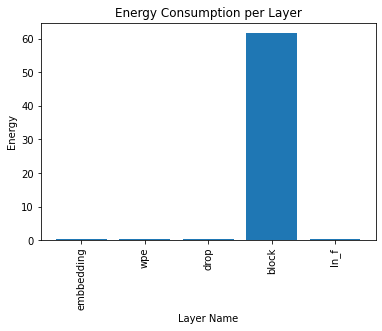

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

df5 = pd.read_csv(csv_file5)

# Plot the values of energy in a bar plot
plt.bar(df5['Layer Name'], df5['Energy(mJ)'])
plt.xlabel('Layer Name')
plt.ylabel('Energy')
plt.title('Energy Consumption per Layer')
plt.xticks(rotation=90)
plt.show()

# Transformer
We download the XLM-R model from the pre-defined torchtext models by following the instructions in torchtext.models. We also set the DEVICE to execute on-accelerator tests. (Enable GPU execution for your environment as appropriate.)


In [141]:
import torch
import torch.nn as nn

print(f"torch version: {torch.__version__}")

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print(f"torch cuda available: {torch.cuda.is_available()}")

import torch, torchtext
from torchtext.models import RobertaClassificationHead
from torchtext.functional import to_tensor
xlmr_large = torchtext.models.XLMR_LARGE_ENCODER
classifier_head = torchtext.models.RobertaClassificationHead(num_classes=2, input_dim = 1024)
model = xlmr_large.get_model(head=classifier_head)
transform = xlmr_large.transform()

torch version: 2.0.1+cu117
torch cuda available: True


In [142]:
model

RobertaModel(
  (encoder): RobertaEncoder(
    (transformer): TransformerEncoder(
      (token_embedding): Embedding(250002, 1024, padding_idx=1)
      (layers): TransformerEncoder(
        (layers): ModuleList(
          (0-23): 24 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (linear1): Linear(in_features=1024, out_features=4096, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=4096, out_features=1024, bias=True)
            (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (positional_embedding): PositionalEmbedding(
        (embedding): Embe

In [8]:
small_input_batch = [
               "Hello world",
               "How are you!","I am aymen"
]
big_input_batch = ["""`Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by
that Antichrist- I really believe he is Antichrist- I will have
nothing more to do with you and you are no longer my friend, no longer
my 'faithful slave,' as you call yourself! But how do you do? I see
I have frightened you- sit down and tell me all the news.`

It was in July, 1805, and the speaker was the well-known Anna
Pavlovna Scherer, maid of honor and favorite of the Empress Marya
Fedorovna. With these words she greeted Prince Vasili Kuragin, a man
of high rank and importance, who was the first to arrive at her
reception. Anna Pavlovna had had a cough for some days. She was, as
she said, suffering from la grippe; grippe being then a new word in
St. Petersburg, used only by the elite."""
]

In [11]:
big_input_string = " ".join(big_input_batch)

# Split the string into words and calculate the number of words
number_of_words = len(big_input_string.split()) 
number_of_words

171

## Power Measurement _ Transformer

In [144]:
import torch
import torch.nn as nn
import subprocess
import multiprocessing
import numpy as np

# Create an empty list to store power measurements


import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F



def measure(q, rq, gpu_id):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=2 -i {gpu_id}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
input_batch=big_input_batch
model.to(DEVICE)
model_input = to_tensor(transform(input_batch), padding_value=1).to(DEVICE)
model.train()
power_measurements = [] 
power_measurements1 = [] 
power_measurements2 = [] 
power_measurements3 = [] 
power_measurements4 = [] 
power_measurements5 = []

for i in range(10):
    # Start the power measurement
    q = multiprocessing.Queue()
    rq = multiprocessing.Queue()
    q1 = multiprocessing.Queue()
    rq1 = multiprocessing.Queue() 
    q2 = multiprocessing.Queue()
    rq2 = multiprocessing.Queue()
    q3 = multiprocessing.Queue()
    rq3 = multiprocessing.Queue()
    q4 = multiprocessing.Queue()
    rq4 = multiprocessing.Queue() 
    q5 = multiprocessing.Queue()
    rq5 = multiprocessing.Queue()



    p = multiprocessing.Process(target=measure, args=(q,rq,1))
    p.start()
    q.put('start')
    m = rq.get()
    print('got' + m)
    assert m == 'started' 
    output = model.encoder.transformer.token_embedding(model_input) 
    q.put('stop') 
    p.join() 


    p1 = multiprocessing.Process(target=measure, args=(q1,rq1,1))
    p1.start()
    q1.put('start')
    m = rq1.get()
    print('got' + m)
    assert m == 'started' 
    layer1 = model.encoder.transformer.layers.layers[0]
    output = layer1(output)
    layer2 = model.encoder.transformer.layers.layers[1]
    output = layer2(output)
    layer3 = model.encoder.transformer.layers.layers[2]
    output = layer3(output)
    layer4 = model.encoder.transformer.layers.layers[3]
    output = layer4(output)
    layer5 = model.encoder.transformer.layers.layers[4]
    output = layer5(output)
    layer6 = model.encoder.transformer.layers.layers[5]
    output = layer6(output)
    layer7 = model.encoder.transformer.layers.layers[6]
    output = layer7(output)
    q1.put('stop') 

    p1.join()

##########################################################################Block2#############################
    p2 = multiprocessing.Process(target=measure, args=(q2,rq2,1))
    p2.start()
    q2.put('start')
    m = rq2.get()
    print('got' + m)
    assert m == 'started' 
    layer8 = model.encoder.transformer.layers.layers[7]
    output = layer8(output)
    layer9 = model.encoder.transformer.layers.layers[8]
    output = layer9(output)
    layer10 = model.encoder.transformer.layers.layers[9]
    output = layer10(output)
    layer11 = model.encoder.transformer.layers.layers[10]
    output = layer11(output) 
    layer12 = model.encoder.transformer.layers.layers[11]
    output = layer12(output)
    layer13 = model.encoder.transformer.layers.layers[12]
    output = layer13(output)
    layer14 = model.encoder.transformer.layers.layers[13]
    output = layer14(output)
    layer15 = model.encoder.transformer.layers.layers[14]
    output = layer15(output)

    q2.put('stop') 
    p2.join()
##########################################################################Block3#############################
    p3 = multiprocessing.Process(target=measure, args=(q3,rq3,1))
    p3.start()
    q3.put('start')
    m = rq3.get()
    print('got' + m)
    assert m == 'started' 
    layer16 = model.encoder.transformer.layers.layers[15]
    output = layer16(output)
    layer17 = model.encoder.transformer.layers.layers[16]
    output = layer17(output)
    layer18 = model.encoder.transformer.layers.layers[17]
    output = layer18(output)
    layer19 = model.encoder.transformer.layers.layers[18]
    output = layer19(output)
    layer20 = model.encoder.transformer.layers.layers[19]
    output = layer20(output)
    layer21 = model.encoder.transformer.layers.layers[20]
    output = layer21(output)
    layer22 = model.encoder.transformer.layers.layers[21]
    output = layer22(output)
    layer23 = model.encoder.transformer.layers.layers[22]
    output = layer23(output)
    q3.put('stop') 
    p3.join()












##########################################################################Block3#############################


    p4 = multiprocessing.Process(target=measure, args=(q4,rq4,1))
    p4.start()
    q4.put('start')
    m = rq4.get()
    print('got' + m)
    assert m == 'started'               
    #x = model.maxpool(x)
    output = model.head(output)
    q4.put('stop')
    

    x = output

    p4.join()

    # Retrieve the power measurements from the queue
    while not rq.empty():
        power_output = rq.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq1.empty():
        power_output = rq1.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements1.append(float(power_output.split()[0]))  # Remov 

    # Retrieve the power measurements from the queue
    while not rq2.empty():
        power_output = rq2.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements2.append(float(power_output.split()[0]))  # Remov

    while not rq3.empty():
        power_output = rq3.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements3.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float 

    # Retrieve the power measurements from the queue
    while not rq4.empty():
        power_output = rq4.get()
        if power_output == 'stop':
            break
        print(power_output)
        power_measurements4.append(float(power_output.split()[0]))  # Remov 



print(x.shape) 
mean_power = np.mean(power_measurements)
print("Mean power: ", mean_power) 
mean_power1 = np.mean(power_measurements1)
print("Mean power1: ", mean_power1) 
mean_power2 = np.mean(power_measurements2)
print("Mean power2: ", mean_power2) 
mean_power3 = np.mean(power_measurements3)
print("Mean power: ", mean_power3) 
mean_power4 = np.mean(power_measurements4)
print("Mean power1: ", mean_power4) 












gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
44.61 W
122.71 W
112.00 W
148.07 W
38.79 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.89 W
107.21 W
116.66 W
105.86 W
38.79 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.89 W
105.37 W
89.93 W
113.21 W
38.79 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.89 W
108.68 W
115.62 W
118.66 W
38.80 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.89 W
79.85 W
116.35 W
97.38 W
38.79 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.89 W
84.52 W
91.34 W
97.56 W
38.79 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.99 W
61.30 W
92.10 W
99.54 W
38.89 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.99 W
84.15 W
92.37 W
94.71 W
38.89 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.98 W
115.42 W
97.51 W
86.29 W
38.89 W
gotstarted
gotstarted
gotstarted
gotstarted
gotstarted
38.89 W
70.10 W
99.53 W
114.22 W
38.80 W
torch.Size([3, 2])
Mean power:  39.4

In [148]:
DEVICE = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
input_batch=big_input_batch
model.to(DEVICE)
model_input = to_tensor(transform(input_batch), padding_value=1).to(DEVICE)
output = model.encoder.transformer.token_embedding(model_input)
#for layer in model.encoder.transformer.layers.layers:
    #output = layer(output) 
layer1 = model.encoder.transformer.layers.layers[0]
output = layer1(output)
layer2 = model.encoder.transformer.layers.layers[1]
output = layer2(output)
layer3 = model.encoder.transformer.layers.layers[2]
output = layer3(output)
layer4 = model.encoder.transformer.layers.layers[3]
output = layer4(output)
layer5 = model.encoder.transformer.layers.layers[4]
output = layer5(output)
layer6 = model.encoder.transformer.layers.layers[5]
output = layer6(output)
layer7 = model.encoder.transformer.layers.layers[6]
output = layer7(output)
layer8 = model.encoder.transformer.layers.layers[7]
output = layer8(output)
layer9 = model.encoder.transformer.layers.layers[8]
output = layer9(output)
layer10 = model.encoder.transformer.layers.layers[9]
output = layer10(output)
layer11 = model.encoder.transformer.layers.layers[10]
output = layer11(output) 
layer12 = model.encoder.transformer.layers.layers[11]
output = layer12(output)
layer13 = model.encoder.transformer.layers.layers[12]
output = layer13(output)
layer14 = model.encoder.transformer.layers.layers[13]
output = layer14(output)
layer15 = model.encoder.transformer.layers.layers[14]
output = layer15(output)
layer16 = model.encoder.transformer.layers.layers[15]
output = layer16(output)
layer17 = model.encoder.transformer.layers.layers[16]
output = layer17(output)
layer18 = model.encoder.transformer.layers.layers[17]
output = layer18(output)
layer19 = model.encoder.transformer.layers.layers[18]
output = layer19(output)
layer20 = model.encoder.transformer.layers.layers[19]
output = layer20(output)
layer21 = model.encoder.transformer.layers.layers[20]
output = layer21(output)
layer22 = model.encoder.transformer.layers.layers[21]
output = layer22(output)

layer23 = model.encoder.transformer.layers.layers[22]
output = layer23(output)

output = model.head(output)


In [101]:
model_input = to_tensor(transform(input_batch), padding_value=1).to(DEVICE)
output = model.encoder.transformer.token_embedding(model_input)
for idx, layer in enumerate(model.encoder.transformer.layers.layers):
    print(f"Layer {idx}: {layer}")


Layer 0: TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
  )
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)
Layer 1: TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
  )
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (norm2): Layer

In [46]:
model.encoder.transformer.layers.enable_nested_tensor


RobertaModel(
  (encoder): RobertaEncoder(
    (transformer): TransformerEncoder(
      (token_embedding): Embedding(250002, 1024, padding_idx=1)
      (layers): TransformerEncoder(
        (layers): ModuleList(
          (0-23): 24 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (linear1): Linear(in_features=1024, out_features=4096, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=4096, out_features=1024, bias=True)
            (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (positional_embedding): PositionalEmbedding(
        (embedding): Embe

In [44]:
model.encoder.transformer.layers.enable_nested_tensor= False


In [149]:
use_cuda = torch.cuda.is_available()
DEVICE= torch.device("cuda:0" if use_cuda else "cpu")
model.to(DEVICE)
model_input = model_input.to(DEVICE)
ITERATIONS = 10 
def forward(model ,model_input):
    with torch.autograd.profiler.record_function("embbedding"):
        output = model.encoder.transformer.token_embedding(model_input)
    with torch.autograd.profiler.record_function("block 1-7"):
        layer1 = model.encoder.transformer.layers.layers[0]
        output = layer1(output)
        layer2 = model.encoder.transformer.layers.layers[1]
        output = layer2(output)
        layer3 = model.encoder.transformer.layers.layers[2]
        output = layer3(output)
        layer4 = model.encoder.transformer.layers.layers[3]
        output = layer4(output)
        layer5 = model.encoder.transformer.layers.layers[4]
        output = layer5(output)
        layer6 = model.encoder.transformer.layers.layers[5]
        output = layer6(output)
        layer7 = model.encoder.transformer.layers.layers[6]
        output = layer7(output)        
    with torch.autograd.profiler.record_function("block 8 - 15"):
        layer8 = model.encoder.transformer.layers.layers[7]
        output = layer8(output)
        layer9 = model.encoder.transformer.layers.layers[8]
        output = layer9(output)
        layer10 = model.encoder.transformer.layers.layers[9]
        output = layer10(output)
        layer11 = model.encoder.transformer.layers.layers[10]
        output = layer11(output) 
        layer12 = model.encoder.transformer.layers.layers[11]
        output = layer12(output)
        layer13 = model.encoder.transformer.layers.layers[12]
        output = layer13(output)
        layer14 = model.encoder.transformer.layers.layers[13]
        output = layer14(output)
        layer15 = model.encoder.transformer.layers.layers[14]
        output = layer15(output)        
    with torch.autograd.profiler.record_function("block16 - 23"): 
        layer16 = model.encoder.transformer.layers.layers[15]
        output = layer16(output)
        layer17 = model.encoder.transformer.layers.layers[16]
        output = layer17(output)
        layer18 = model.encoder.transformer.layers.layers[17]
        output = layer18(output)
        layer19 = model.encoder.transformer.layers.layers[18]
        output = layer19(output)
        layer20 = model.encoder.transformer.layers.layers[19]
        output = layer20(output)
        layer21 = model.encoder.transformer.layers.layers[20]
        output = layer21(output)
        layer22 = model.encoder.transformer.layers.layers[21]
        output = layer22(output)
        layer23 = model.encoder.transformer.layers.layers[22]
        output = layer23(output)       
    with torch.autograd.profiler.record_function("head"):
        output = model.head(output)

        return output
print("fast path:")
print("==========")
for i in range(ITERATIONS):
    profiler = torch.autograd.profiler.profile(enabled=True, use_cuda=True, record_shapes=True) 
    with profiler:
        with torch.no_grad():
            output = forward(model,model_input)
profiling_results6 = profiler.key_averages().table()
print(profiling_results6)


########################################################################################################




fast path:


STAGE:2023-05-21 14:50:11 27936:27936 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-21 14:50:12 27936:27936 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-21 14:50:12 27936:27936 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-21 14:50:12 27936:27936 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-21 14:50:12 27936:27936 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-21 14:50:12 27936:27936 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-21 14:50:13 27936:27936 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-21 14:50:13 27936:27936 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-21 14:50:13 27936:27936 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-21 14:50:13 27936:27936 ActivityProfilerController.cpp:311] Co

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             embbedding         0.23%     150.000us         0.48%     315.000us     315.000us     152.000us         0.23%     321.000us     321.000us             1  
                                        aten::embedding         0.07%      49.000us         0.25%     165.000us     165.000us      32.000us         0.05%     169.000us     169.000us             1  
         

## Table

In [105]:
import csv
import re
import pandas as pd

# Split the profiler table into lines
lines = profiling_results6.strip().split('\n')

# Define the layer names
layer_names = ['embbedding','block 1-7','block 8 - 15','block16 - 23','head']
power_measurements = [mean_power, mean_power1, mean_power2, mean_power3, mean_power4]

# Extract the 'CUDA time avg' values for the specified layers
cuda_time_avgs = {}
for layer_name in layer_names:
    layer_line = next(line for line in lines if layer_name in line)
    cuda_time_avg_us = re.findall(r'\d+\.\d+(?:us|ms)', layer_line)[-1]
    cuda_time_avg_ms = float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0]) / 1000 if 'us' in cuda_time_avg_us else float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0])
    cuda_time_avgs[layer_name] = cuda_time_avg_ms

# Calculate the energy by multiplying CUDA time avg and power measurements
energy_values = [cuda_time_avgs[layer_name] * power_measurements[i] for i, layer_name in enumerate(layer_names)]

# Save the results in a CSV file
csv_file6 = 'profiler_results_Transformer.csv'
with open(csv_file6, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Layer Name', 'CUDA Time Avg (ms)', 'Power Measurements(W)', 'Energy(mJ)'])
    for i, layer_name in enumerate(layer_names):
        writer.writerow([layer_name, cuda_time_avgs[layer_name], power_measurements[i], energy_values[i]])

print(f"Profiler results saved in '{csv_file6}'.")

# Read the CSV file
df6 = pd.read_csv(csv_file6)

# Display the table
display(df6)


NameError: name 'profiling_results6' is not defined

In [ ]:
import pandas as pd

# Calculate the sum of energy for all layers
total_energy = df1['Energy(mJ)'].sum()

# Extract the self CUDA time from the profiling results
self_cuda_time = self_cuda_time_total
power_idle = 38
# Multiply self CUDA time by X (adjust the value of X according to your needs)
X =average_above_90th - power_idle
result = self_cuda_time * X

# Create a new DataFrame with two columns
new_df = pd.DataFrame({'Sum of Energy': [total_energy], 'Self CUDA Time * X': [result]})

display(new_df)

## BAR plot

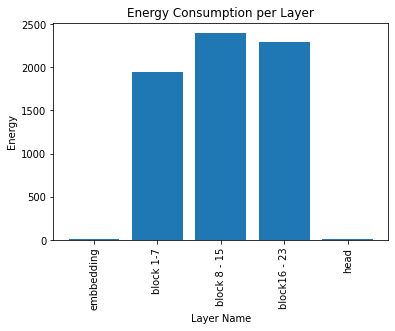

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

df6 = pd.read_csv(csv_file6)

# Plot the values of energy in a bar plot
plt.bar(df6['Layer Name'], df6['Energy(mJ)'])
plt.xlabel('Layer Name')
plt.ylabel('Energy')
plt.title('Energy Consumption per Layer')
plt.xticks(rotation=90)
plt.show()

# EmbeedingNet

In [65]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [66]:
plt.style.use('ggplot')

In [67]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [68]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

## dataset Downloading

In [69]:
def try_download(url, download_path):
    archive_name = url.split('/')[-1]
    folder_name, _ = os.path.splitext(archive_name)
    
    try:
        r = urlopen(url)
    except URLError as e:
        print('Cannot download the data. Error: %s' % s)
        return 

    assert r.status == 200
    data = r.read()

    with zipfile.ZipFile(io.BytesIO(data)) as arch:
        arch.extractall(download_path)
        
    print('The archive is extracted into folder: %s' % download_path)

In [70]:
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
        elif filename.suffix == '.dat':
            if filename.stem == 'ratings':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(filename, sep='::', names=columns, engine='python')
            files[filename.stem] = data
    return files['ratings'], files['movies']

In [71]:
# pick any other dataset instead
archive_url = f'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
download_path = Path.home() / 'data' / 'movielens'

In [72]:
try_download(archive_url, download_path)


The archive is extracted into folder: /home/daouda/data/movielens


In [73]:
!ls -l $download_path

total 8
drwxrwxr-x 2 daouda g-daouda 4096 May 24 02:23 ml-1m
drwxrwxr-x 2 daouda g-daouda 4096 May 24 02:35 ml-latest-small


In [74]:
# pick one of the available folders
ratings, movies = read_data(download_path / 'ml-latest-small')


In [75]:
ratings.head()
ratings.shape

(100836, 4)

In [76]:
movies.head()
movies.shape

(9742, 3)

In [77]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [78]:
tabular_preview(ratings, movies)


movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


### Data preperation

In [79]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [80]:
(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 610 users, 9724 movies
Dataset shape: (100836, 2)
Target shape: (100836,)


In [81]:

class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [82]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [83]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 224,  472],
        [ 532, 3638],
        [ 124, 4813],
        [ 262,  348]])
tensor([[3.],
        [5.],
        [2.],
        [5.]])


Embeddings

As it is a natural language dataset, embedding has to be done. We haved done it with neural based embedding, we can also try other embedding methods availble like word2vec, glove or Onehot encoding.

In [84]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [85]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)


EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [86]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])


EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

Cyclical Learning Rate (CLR)

One of the fastai library features is the cyclical learning rate scheduler. We can implement something similar inheriting the _LRScheduler class from the torch library. Following the original paper's pseudocode, this CLR Keras callback implementation, and making a couple of adjustments to support cosine annealing with restarts, let's create our own CLR scheduler.

The implementation of this idea is quite simple. The base PyTorch scheduler class has the get_lr() method that is invoked each time when we call the step() method. The method should return a list of learning rates depending on the current training epoch. In our case, we have the same learning rate for all of the layers, and therefore, we return a list with a single value.

The next cell defines a CyclicLR class that expectes a single callback function. This function should accept the current training epoch and the base value of learning rate, and return a new learning rate value.

In [87]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [88]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [89]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [90]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

## Training Loop


In [91]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [92]:
minmax = float(ratings.rating.min()), float(ratings.rating.max())
minmax

(0.5, 5.0)

In [93]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [94]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

In [95]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False

        running_loss = 0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            #print(x_batch[:,0])
          
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/100] train: 0.9952 - val: 0.8541
loss improvement on epoch: 2
[002/100] train: 0.7764 - val: 0.8089
loss improvement on epoch: 3
[003/100] train: 0.7242 - val: 0.7702
loss improvement on epoch: 4
[004/100] train: 0.6537 - val: 0.7633
loss improvement on epoch: 5
[005/100] train: 0.6590 - val: 0.7537
[006/100] train: 0.6124 - val: 0.7542
[007/100] train: 0.6229 - val: 0.7609
[008/100] train: 0.5840 - val: 0.7668
[009/100] train: 0.5903 - val: 0.7740
[010/100] train: 0.5448 - val: 0.7794
[011/100] train: 0.5488 - val: 0.7923
[012/100] train: 0.4897 - val: 0.8074
[013/100] train: 0.4851 - val: 0.8192
[014/100] train: 0.4223 - val: 0.8480
[015/100] train: 0.4196 - val: 0.8516
early stopping after epoch 015


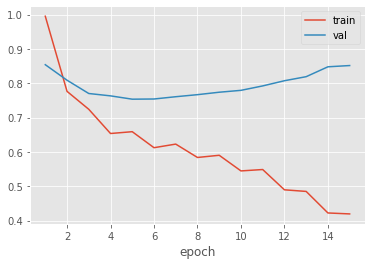

In [96]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')


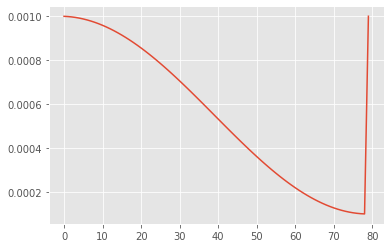

In [97]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])


In [98]:
net.load_state_dict(best_weights)


<All keys matched successfully>

## Inference

In [99]:
net.eval()

EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

In [100]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [101]:
print(groud_truth )

[3.  5.  2.  ... 3.5 4.  4.5]


In [102]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8683


## layer / block power measurement 

In [120]:
groud_truth1, predictions1 = [], []
def measure(q, rq, gpu_id):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=2 -i {gpu_id}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)

device = torch.device("cuda:0" if use_cuda else "cpu")
user_input = x_batch[:, 0].to(device)
movie_input = x_batch[:, 1].to(device)
net.to(device)
power_measurements = [] 
power_measurements1 = []
power_measurements2 = []
power_measurements3 = []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=2048):
        x_batch, y_batch = [b.to(device) for b in batch]
#############################################################################
        # Assuming x_batch[:, 0] represents user input and x_batch[:, 1] represents movie input

        q = multiprocessing.Queue()
        rq = multiprocessing.Queue() 
        q1 = multiprocessing.Queue()
        rq1 = multiprocessing.Queue() 
        q2 = multiprocessing.Queue()
        rq2 = multiprocessing.Queue() 
        q3 = multiprocessing.Queue()
        rq3 = multiprocessing.Queue()
        
        p = multiprocessing.Process(target=measure, args=(q,rq,1))
        p.start()
        q.put('start')
        m = rq.get()
        print('got' + m)
        assert m == 'started' 
        user_embedding = net.u(user_input)
        movie_embedding = net.m(movie_input)
        q.put('stop')
        p.join() 


        p1 = multiprocessing.Process(target=measure, args=(q1,rq1,1))
        p1.start()
        q1.put('start')
        m = rq1.get()
        print('got' + m)
        assert m == 'started' 
        x = torch.cat([user_embedding, movie_embedding], dim=1)
        x = net.drop(x)
        q1.put('stop')
        p1.join() 





        p2 = multiprocessing.Process(target=measure, args=(q2,rq2,1))
        p2.start()
        q2.put('start')
        m = rq2.get()
        print('got' + m)
        assert m == 'started' 
        x = net.hidden[0](x)
        x = net.hidden[1](x)
        x = net.hidden[2](x)
        x = net.hidden[3](x)
        x = net.hidden[4](x)
        x = net.hidden[5](x)
        x = net.hidden[6](x)
        x = net.hidden[7](x)
        x = net.hidden[8](x)
        q2.put('stop')
        p2.join() 

        p3 = multiprocessing.Process(target=measure, args=(q3,rq3,1))
        p3.start()
        q3.put('start')
        m = rq3.get()
        print('got' + m)
        assert m == 'started' 
        outputs = net.fc(x) 
        q3.put('stop')
        p3.join()  

        # Retrieve the power measurements from the queue
        while not rq.empty():
            power_output = rq.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float

        while not rq1.empty():
            power_output = rq1.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements1.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float

        while not rq2.empty():
            power_output = rq2.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements2.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float

        while not rq3.empty():
            power_output = rq3.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements3.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float





#########################################################################
        groud_truth1.extend(y_batch.tolist())
        predictions1.extend(outputs.tolist())
print(outputs.shape) 
mean_power = np.mean(power_measurements)
print("Mean power: ", mean_power) 
mean_power1 = np.mean(power_measurements1)
print("Mean power1: ", mean_power1)
mean_power2 = np.mean(power_measurements2)
print("Mean power2: ", mean_power2) 
mean_power3 = np.mean(power_measurements3)
print("Mean power3: ", mean_power3)


groud_truth1 = np.asarray(groud_truth).ravel()
predictions1 = np.asarray(predictions).ravel()

use_cuda :  True
gotstarted
gotstarted
gotstarted
gotstarted
38.89 W
38.99 W
39.74 W
38.80 W
gotstarted
gotstarted
gotstarted
gotstarted
38.90 W
38.99 W
39.67 W
38.69 W
gotstarted
gotstarted
gotstarted
gotstarted
38.99 W
39.08 W
39.49 W
38.89 W
gotstarted
gotstarted
gotstarted
gotstarted
38.90 W
39.09 W
39.77 W
38.79 W
gotstarted
gotstarted
gotstarted
gotstarted
38.98 W
38.98 W
39.57 W
38.80 W
gotstarted
gotstarted
gotstarted
gotstarted
38.89 W
38.98 W
40.06 W
38.89 W
gotstarted
gotstarted
gotstarted
gotstarted
38.89 W
39.00 W
39.76 W
38.80 W
gotstarted
gotstarted
gotstarted
gotstarted
38.99 W
38.99 W
39.78 W
38.80 W
gotstarted
gotstarted
gotstarted
gotstarted
39.00 W
38.99 W
39.96 W
38.80 W
torch.Size([1024, 1])
Mean power:  38.93666666666667
Mean power1:  39.010000000000005
Mean power2:  39.75555555555556
Mean power3:  38.80666666666667


##  power measurement 

In [121]:
groud_truth1, predictions1 = [], []
def measure(q, rq, gpu_id):
    while True:
        # Wait for start signal
        start_signal = q.get()
        if start_signal != 'start':
            continue
            
        cmd = f"nvidia-smi --query-gpu=power.draw --format=csv,noheader --loop-ms=2 -i {gpu_id}"
        process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        rq.put('started')

        # Read and print power measurements until stop signal is received
        while True:
            power_output = process.stdout.readline().decode().strip()
            rq.put(power_output)
            if not power_output:
                break

            if q.get() == 'stop':
                process.kill()
                return

        # Exit the loop if the stop signal is received
        if q.get() =='':
            break


use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)

device = torch.device("cuda:0" if use_cuda else "cpu")
user_input = x_batch[:, 0].to(device)
movie_input = x_batch[:, 1].to(device)
net.to(device)
power_measurements = [] 
power_measurements1 = []
power_measurements2 = []
power_measurements3 = []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=1024):
        x_batch, y_batch = [b.to(device) for b in batch]
#############################################################################
        # Assuming x_batch[:, 0] represents user input and x_batch[:, 1] represents movie input

        q = multiprocessing.Queue()
        rq = multiprocessing.Queue() 

        
        p = multiprocessing.Process(target=measure, args=(q,rq,1))
        p.start()
        q.put('start')
        m = rq.get()
        print('got' + m)
        assert m == 'started' 
        user_embedding = net.u(user_input)
        movie_embedding = net.m(movie_input)




        x = torch.cat([user_embedding, movie_embedding], dim=1)
        x = net.drop(x)







        x = net.hidden[0](x)
        x = net.hidden[1](x)
        x = net.hidden[2](x)
        x = net.hidden[3](x)
        x = net.hidden[4](x)
        x = net.hidden[5](x)
        x = net.hidden[6](x)
        x = net.hidden[7](x)
        x = net.hidden[8](x)
 
        outputs = net.fc(x) 
        q.put('stop')
        p.join() 
        
        # Retrieve the power measurements from the queue
        while not rq.empty():
            power_output = rq.get()
            if power_output == 'stop':
                break
            print(power_output)
            power_measurements.append(float(power_output.split()[0]))  # Remove the "W" string and convert to float





#########################################################################
        groud_truth1.extend(y_batch.tolist())
        predictions1.extend(outputs.tolist())
print(outputs.shape) 
mean_power = np.mean(power_measurements)
print("Mean power: ", mean_power) 


use_cuda :  True
gotstarted
40.83 W
gotstarted
40.34 W
gotstarted
40.74 W
gotstarted
40.63 W
gotstarted
40.64 W
gotstarted
40.35 W
gotstarted
40.63 W
gotstarted
40.83 W
gotstarted
40.83 W
gotstarted
40.63 W
gotstarted
40.33 W
gotstarted
40.44 W
gotstarted
40.15 W
gotstarted
40.14 W
gotstarted
40.44 W
gotstarted
40.74 W
gotstarted
40.54 W
gotstarted
40.35 W
gotstarted
40.33 W
torch.Size([2048, 1])
Mean power:  40.52157894736842


In [122]:
groud_truth, predictions = [], []
for batch in batches(*datasets['val'], shuffle=False, bs=bs):
    x_batch, y_batch = [b.to(device) for b in batch]
    outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
    groud_truth.extend(y_batch.tolist())
    predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [132]:
predictions1

array([3.38736439, 4.29216433, 3.50974274, ..., 3.65618658, 3.57996368,
       3.64016676])

In [133]:
final_loss = np.sqrt(np.mean((predictions1 - groud_truth1)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8683


In [104]:
use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)
print(torch.cuda.get_device_name(0))

device = torch.device("cuda:0" if use_cuda else "cpu") 
net = net.to(device)
user_input = x_batch[:, 0].to(device)
movie_input = x_batch[:, 1].to(device)
def forward():
    for batch in batches(*datasets['val'], shuffle=False, bs=1024):
        x_batch, y_batch = [b.to(device) for b in batch]


        with torch.autograd.profiler.record_function("u-embedding"):
            user_embedding = net.u(user_input)
            movie_embedding = net.m(movie_input)
        with torch.autograd.profiler.record_function("drop-net"):
            x = torch.cat([user_embedding, movie_embedding], dim=1)
            x = net.drop(x)
        with torch.autograd.profiler.record_function("hidden-net"):
            x = net.hidden[0](x)
            x = net.hidden[1](x)
            x = net.hidden[2](x)
            x = net.hidden[3](x)
            x = net.hidden[4](x)
            x = net.hidden[5](x)
            x = net.hidden[6](x)
            x = net.hidden[7](x)
            x = net.hidden[8](x)
        with torch.autograd.profiler.record_function("fc-net"):
            outputs = net.fc(x) 

        return outputs


#FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor


# Run the model and record the inference time of each layer
for i in range(10):
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        profiler = torch.autograd.profiler.profile(enabled=True, use_cuda=True, record_shapes=True) 
        net(x_batch[:, 0], x_batch[:, 1], minmax)
        with profiler:
            with torch.no_grad():
                outputs = forward()
    # Get the table of profiling results
profiling_results9 = profiler.key_averages().table()
print(profiling_results9) 











use_cuda :  True
Tesla V100-PCIE-32GB


STAGE:2023-05-31 12:46:41 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 12:46:41 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 12:46:41 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 12:46:41 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 12:46:41 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 12:46:41 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 12:46:41 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 12:46:41 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 12:46:41 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 12:46:41 63839:63839 ActivityProfilerController.cpp:311] Co

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                       aten::lift_fresh         0.15%       2.000us         0.15%       2.000us       1.000us      25.000us         1.84%      25.000us      12.500us             2  
                                               aten::to         1.60%      21.000us        23.53%     308.000us      61.600us      30.000us         2.21%     323.000us      64.600us             5  
         

STAGE:2023-05-31 12:46:42 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 12:46:42 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 12:46:42 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 12:46:42 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 12:46:42 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 12:46:42 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 12:46:42 63839:63839 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-05-31 12:46:42 63839:63839 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-05-31 12:46:42 63839:63839 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-05-31 12:46:42 63839:63839 ActivityProfilerController.cpp:321] Co

In [115]:
import csv
import re
import pandas as pd

# Split the profiler table into lines
lines = profiling_results9.strip().split('\n')

# Define the layer names
layer_names = ['u-embedding','drop-net','hidden-net','fc-net']
power_measurements = [mean_power, mean_power1, mean_power2, mean_power3]

# Extract the 'CUDA time avg' values for the specified layers
cuda_time_avgs = {}
for layer_name in layer_names:
    layer_line = next(line for line in lines if layer_name in line)
    cuda_time_avg_us = re.findall(r'\d+\.\d+(?:us|ms)', layer_line)[-1]
    cuda_time_avg_ms = float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0]) / 1000 if 'us' in cuda_time_avg_us else float(re.findall(r'\d+\.\d+', cuda_time_avg_us)[0])
    cuda_time_avgs[layer_name] = cuda_time_avg_ms

# Calculate the energy by multiplying CUDA time avg and power measurements
energy_values = [cuda_time_avgs[layer_name] * power_measurements[i] for i, layer_name in enumerate(layer_names)]

# Save the results in a CSV file
csv_file9 = 'profiler_results_embeddingNet.csv'
with open(csv_file9, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Layer Name', 'CUDA Time Avg (ms)', 'Power Measurements(W)', 'Energy(mJ)'])
    for i, layer_name in enumerate(layer_names):
        writer.writerow([layer_name, cuda_time_avgs[layer_name], power_measurements[i], energy_values[i]])

print(f"Profiler results saved in '{csv_file9}'.")

# Read the CSV file
df9 = pd.read_csv(csv_file9)

# Display the table
display(df9)

Profiler results saved in 'profiler_results_embeddingNet.csv'.


,Layer Name,CUDA Time Avg (ms),Power Measurements(W),Energy(mJ)
0,u-embedding,0.181,38.975032,7.054481
1,drop-net,0.073,39.049363,2.850604
2,hidden-net,0.610,40.624777,24.781114
3,fc-net,0.141,38.870510,5.480742


In [117]:
import pandas as pd

# Calculate the sum of energy for all layers
total_energy = df9['Energy(mJ)'].sum()

# Extract the self CUDA time from the profiling results
self_cuda_time = 1.357
power_idle = 38
# Multiply self CUDA time by X (adjust the value of X according to your needs)
X =40.42
result = self_cuda_time * X

# Create a new DataFrame with two columns
new_df = pd.DataFrame({'Sum of Energy': [total_energy], 'Self CUDA Time * X': [result]})

display(new_df)

,Sum of Energy,Self CUDA Time * X
0,40.16694,54.84994


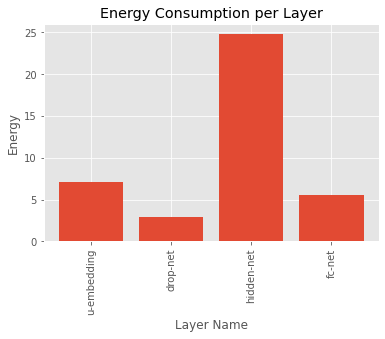

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

df9 = pd.read_csv(csv_file9)

# Plot the values of energy in a bar plot
plt.bar(df9['Layer Name'], df9['Energy(mJ)'])
plt.xlabel('Layer Name')
plt.ylabel('Energy')
plt.title('Energy Consumption per Layer')
plt.xticks(rotation=90)
plt.show()